In [1]:
using Revise
using Pkg
TAMBO_PATH = "/Users/jlazar/research/TAMBO-MC/Tambo/"
Pkg.activate(TAMBO_PATH)
using Tambo
using StatsBase
using Distributions
using JLD2
using Glob

include("../figures/paperstyle.jl")

  Activating project at `~/research/TAMBO-MC/Tambo`
[ Info: Precompiling Tambo [d9a96183-4919-46da-8188-64ea4e10e0ed]
ERROR: LoadError: UndefVarError: `InjectionEvent` not defined
Stacktrace:
 [1] top-level scope
   @ ~/research/TAMBO-MC/Tambo/src/samplers/angularsamplers.jl:46
 [2] include(mod::Module, _path::String)
   @ Base ./Base.jl:457
 [3] include(x::String)
   @ Tambo ~/research/TAMBO-MC/Tambo/src/Tambo.jl:1
 [4] top-level scope
   @ ~/research/TAMBO-MC/Tambo/src/Tambo.jl:35
 [5] include
   @ ./Base.jl:457 [inlined]
 [6] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)
   @ Base ./loading.jl:2049
 [7] top-level scope
   @ stdin:3
in expression starting at /Users/jlazar/research/TAMBO-MC/Tambo/src/samplers/angularsamplers.jl:46
in expression starting at /Users/jlazar/research/TAMBO-MC/Tambo/src/Tambo.jl:1
in expression 

LoadError: Failed to precompile Tambo [d9a96183-4919-46da-8188-64ea4e10e0ed] to "/Users/jlazar/.julia/compiled/v1.9/Tambo/jl_oOlqzM".

In [211]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

ALTMIN = 1.8925255158436627units.km
ALTMAX = 4.092525515843662units.km

EDGES = 10 .^ LinRange(14.5, 18, 15)
CENTS = (EDGES[1:end-1] + EDGES[2:end]) / 2
WIDTHS = EDGES[2:end] - EDGES[1:end-1];

# First, I want to make sure that our new simulation is compatible with our old simulation

In [212]:
# We will use this
HISTS = zeros((2, 3, 2, length(CENTS))); # new/old x inj/dia/sdc x weight/variance

function is_in_zenith_range(event::Tambo.InjectionEvent, θmin=0.0, θmax=π/2) :: Bool
    return θmin < event.initial_state.direction.θ && event.initial_state.direction.θ < θmax
end

is_in_zenith_range (generic function with 3 methods)

## Let's first compute this for injection level

### First we compute the rate as a funciton of energy for the new simulation

In [241]:
sim_fs = glob("00000_00???/GraphNet_00000_00???.jld2", "/Users/jlazar/Downloads/GraphNet_00000/")

HISTS[1, 1, :, :] .= 0

for (idx, sim_f) in enumerate(sim_fs)
    
    # Load and configure
    sim = jldopen(sim_f)
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    # Maks events in proper zenith range
    zenith_mask = is_in_zenith_range.(sim["injected_events"])
    events = sim["injected_events"][zenith_mask]
    
    # Calculate rates
    # fluxes = ones(size(events["initial_state"]["energy"]))
    fluxes = Φ.(events["initial_state"]["energy"])
    weights = Tambo.oneweight.(
        events,
        Ref(injector),
        Ref(injector.xs),
        # Ref(injector.powerlaw),
        # Ref(injector.anglesampler),
        # Ref(injector.injectionvolume),
        # Ref(geo)
    ) / (config.n * length(sim_fs))
    rates = weights .* fluxes
    
    # Histogram events
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates),
        EDGES
    )
    
    HISTS[1, 1, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates .^ 2),
        EDGES
    )
    HISTS[1, 1, 2, :] += h2.weights
    
    close(sim)
    
end

### Now we compute it again for the old simulation

In [232]:
sim_fs = ["/Users/jlazar/Downloads/Oct16th2023_WhitePaper_300k.jld2"]

HISTS[2, 1, : ,:] .= 0

for (idx, sim_f) in enumerate(sim_fs)
    sim = jldopen(sim_f)
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    zenith_mask = is_in_zenith_range.(sim["injected_events"])

    
    events = sim["injected_events"][zenith_mask]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    weights = Tambo.oneweight.(
        events,
        Ref(injector),
        Ref(injector.xs),
        # Ref(injector.xs),
        # Ref(injector.powerlaw),
        # Ref(injector.anglesampler),
        # Ref(injector.injectionvolume),
        # Ref(geo)
    ) / (config.n * length(sim_fs))
    rates = weights .* fluxes
    
    ## For all events ##
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates),
        EDGES
    )
    HISTS[2, 1, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates .^ 2),
        EDGES
    )
    HISTS[2, 1, 2, :] += h2.weights
    
    close(sim)
    
end

### And now we make the plot

A few things to point out:
1. The bands surrounding each line are the $5\sigma$ uncertainties, _i.e._ we have pretty good knowledge of our rates.
1. As expected the uncertainty is constant with energy for the $\gamma=1$ case and grows with energy for the $\gamma=2$ case.
1. It does not seem to be falling off like $E^{-2.37}$. I will investigate this later...

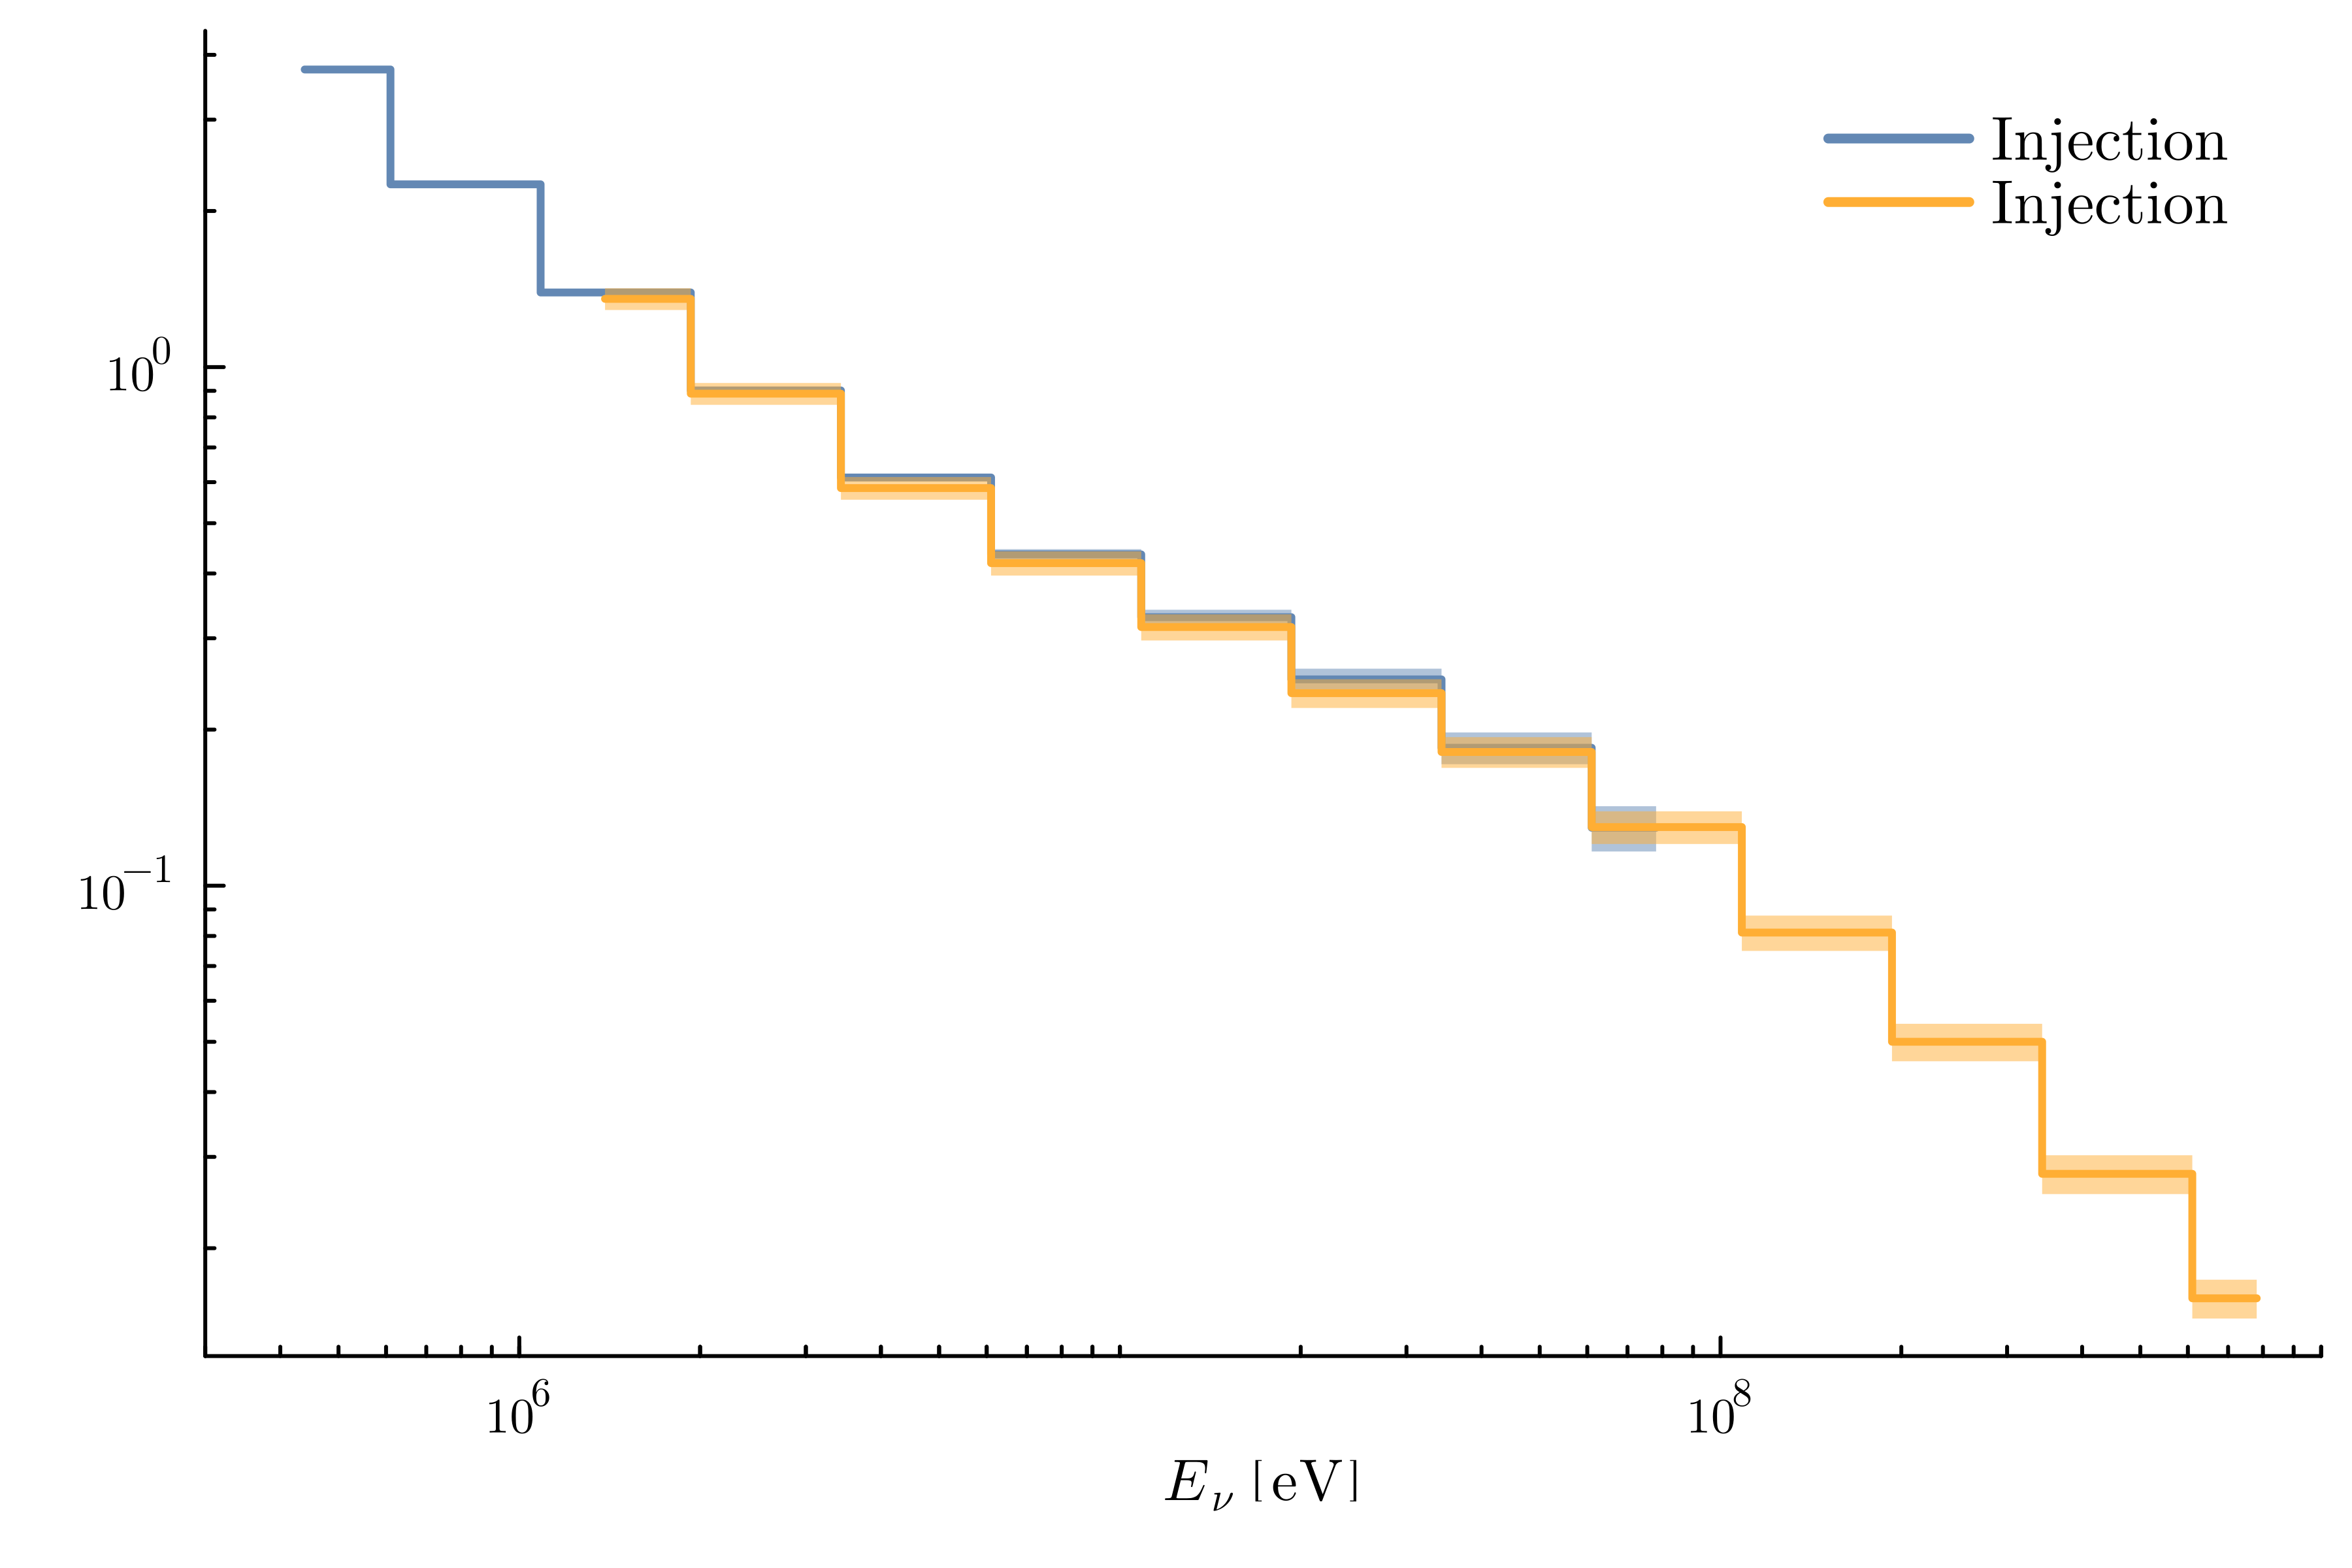

In [236]:
plt = plot(
    xscale=:log10,
    yscale=:log10,
    # yaxis=(:log10, [:auto, :auto]),
    xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
    bottommargin=3mm,
    leftmargin=3mm,
    xlimits=(3e5, 1e9),
    size=(600, 400)
)

for idx in 1:2

    label = idx==1 ? "New" : "Old"

    rate = HISTS[idx, 1, 1, :] * units.second * 10^7.5
    err = 5 * sqrt.(HISTS[idx, 1, 2, :]) * units.second * 10^7.5
    m = rate .> 0

    plot!(
        plt,
        CENTS[m] ./ units.GeV,
        rate[m],
        label="Injection",
        ribbon=err[m],
        linetype=:stepmid
    )
end

display(plt)

### Let's find out if these are equal, _i.e._ if there difference is consistent with 0

It seems that they are close to 0, but there are still definitely some systematic differences...

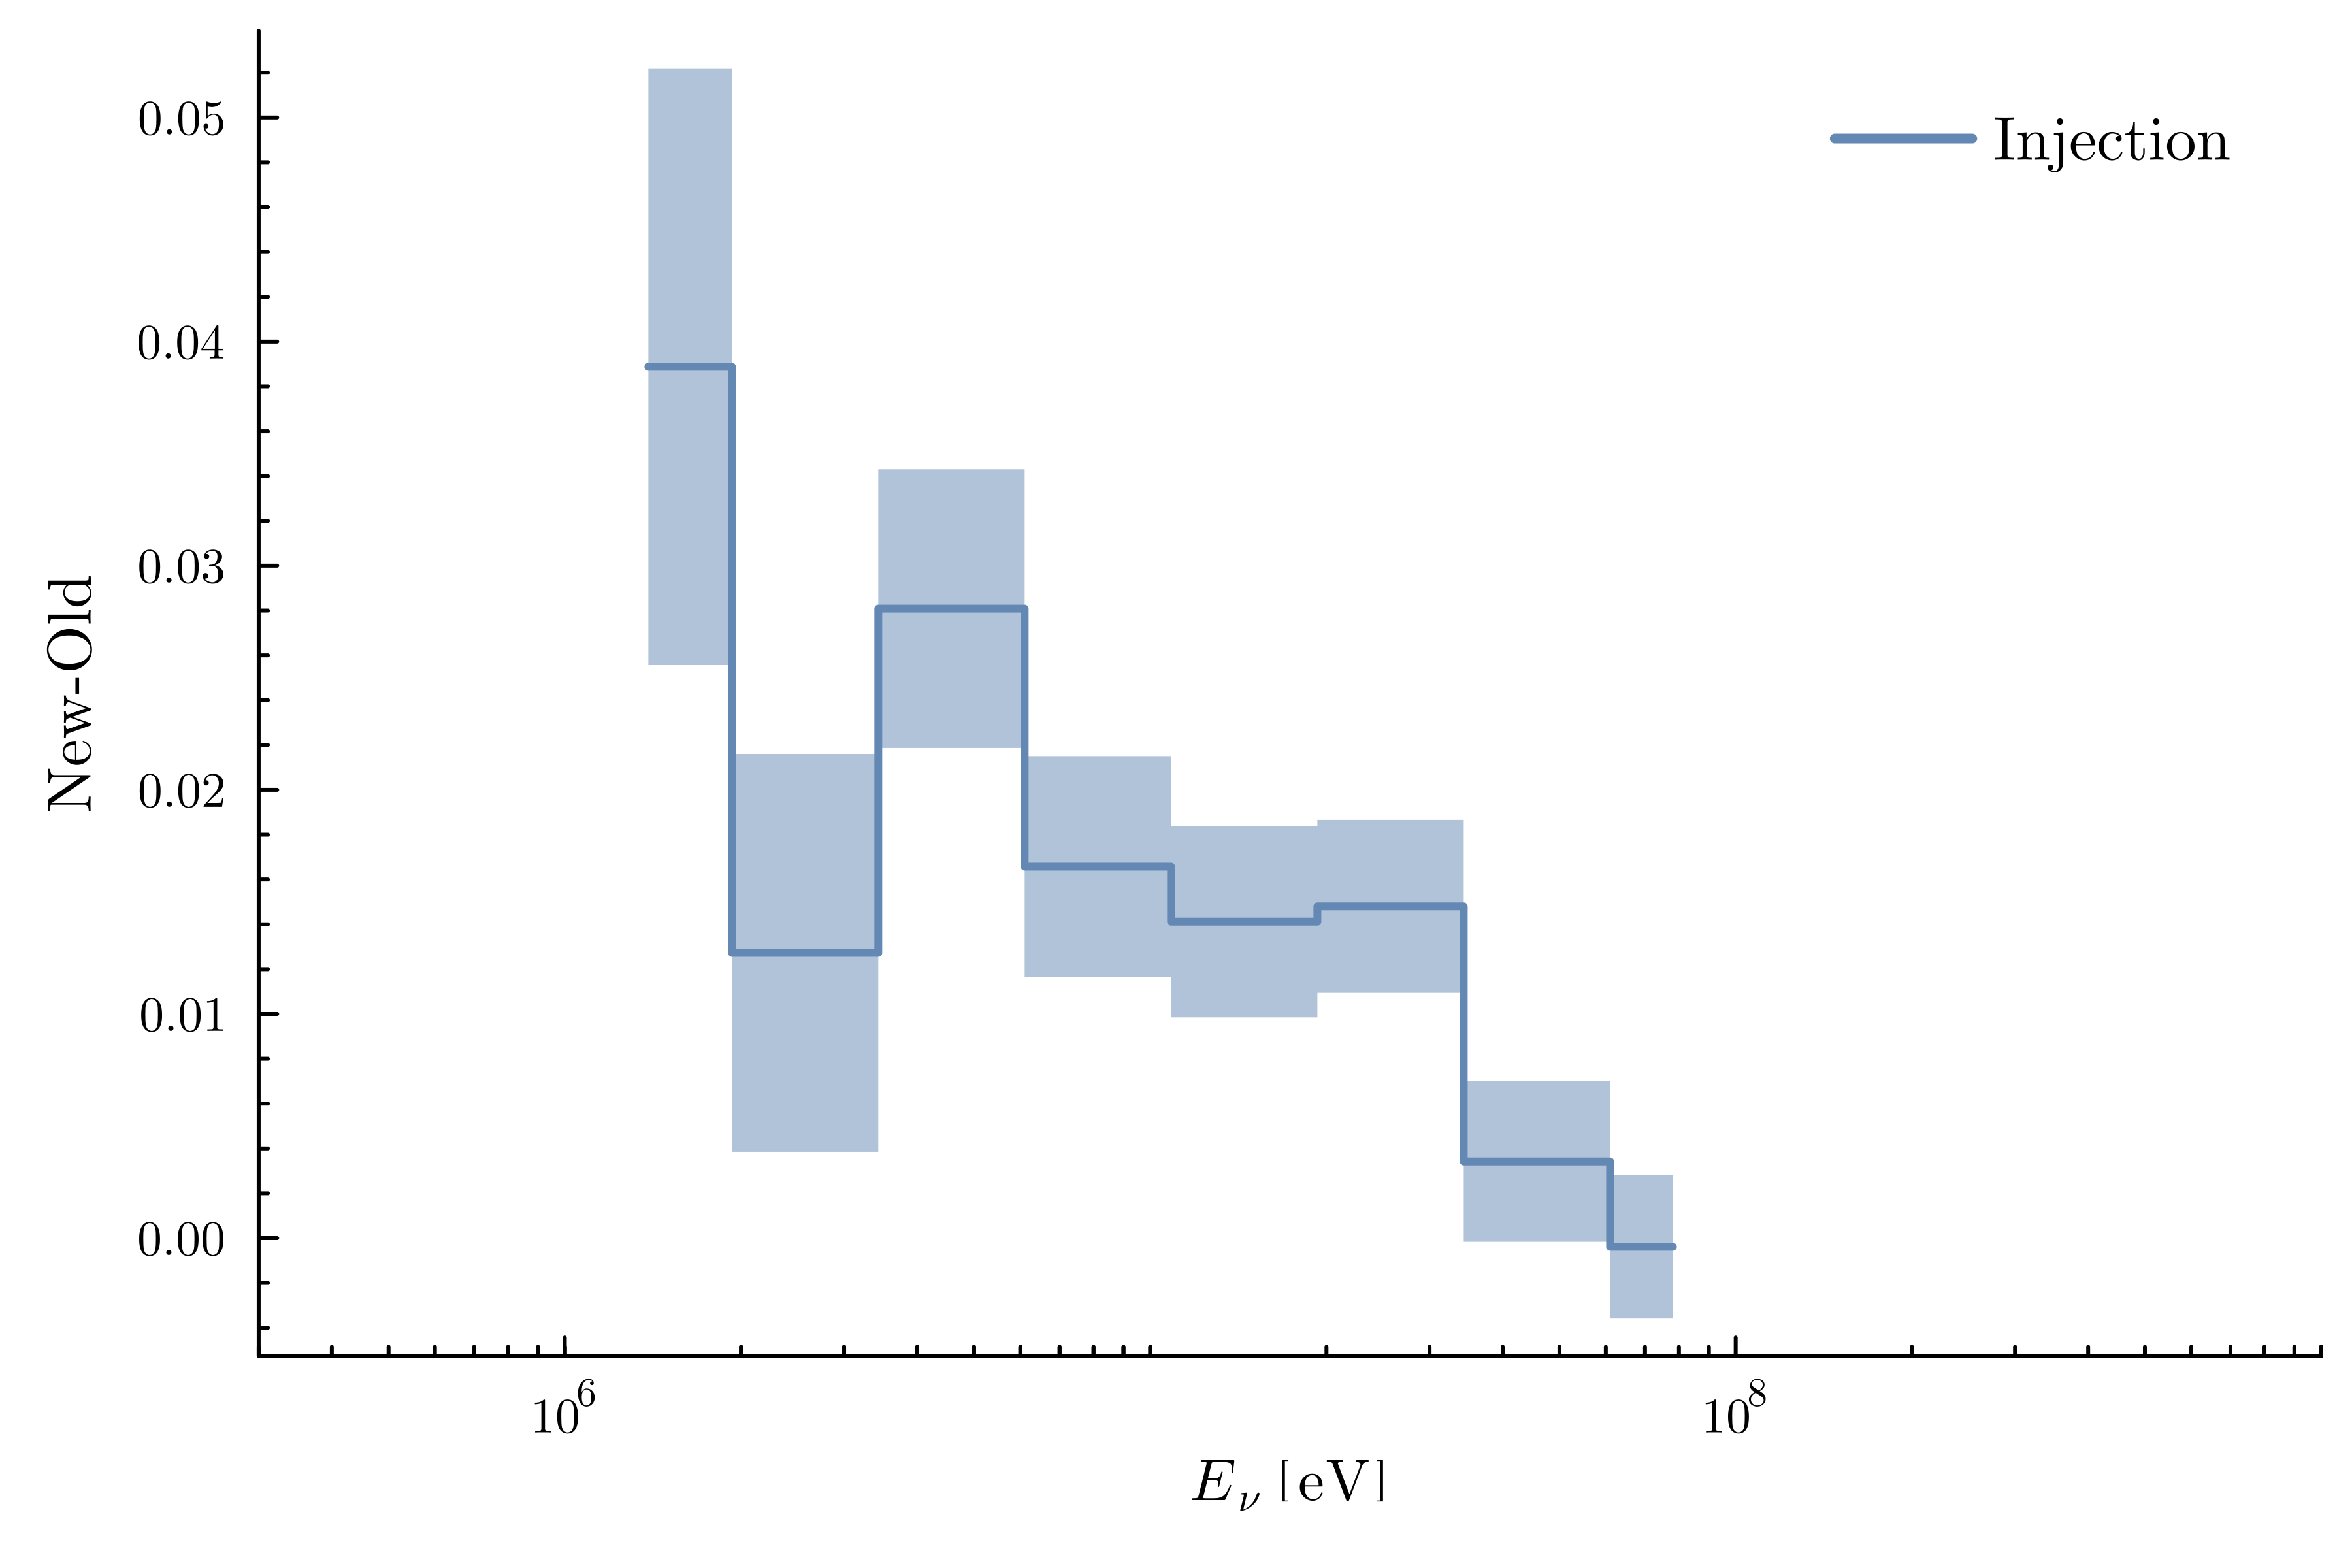

In [237]:
plt = plot(
    xscale=:log10,
    xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
    ylabel="New-Old",
    bottommargin=3mm,
    leftmargin=3mm,
    xlimits=(3e5, 1e9),
    size=(600, 400)
)

rate1 = HISTS[1, 1, 1, :] * units.second * 10^7.5
err1 = sqrt.(HISTS[1, 1, 2, :]) * units.second * 10^7.5
rate2 = HISTS[2, 1, 1, :] * units.second * 10^7.5
err2 = sqrt.(HISTS[2, 1, 2, :]) * units.second * 10^7.5
m = rate1 .> 0 .&& rate2 .> 0

plot!(
    plt,
    CENTS[m] ./ units.GeV,
    rate1[m] - rate2[m],
    label="Injection",
    ribbon=sqrt.(err1[m] .^2 + err2[m] .^2),
    linetype=:stepmid
)

display(plt)

## Now we will run the same procedure, but checking only particle which decayed in air, and which we run CORSIKA on

In [217]:
sim_fs = glob("00000_00???/GraphNet_00000_00???.jld2", "/Users/jlazar/Downloads/GraphNet_00000/")

HISTS[1, 2:3, :, :] .= 0

for (idx, sim_f) in enumerate(sim_fs)
    
    # Load and configure
    sim = jldopen(sim_f)
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    # Mask proper zenith range
    zenith_mask = is_in_zenith_range.(sim["injected_events"])
    events = sim["injected_events"][zenith_mask]
    
    # Calculate decay in air and should do CORSIKA masks
    dia_mask = .~Tambo.inside.(sim["proposal_events"][zenith_mask]["propped_state"]["position"], Ref(geo))
    sdc_mask = Tambo.should_do_corsika.(sim["proposal_events"][zenith_mask], Ref(plane), Ref(geo))
    
    # Calculate rates
    fluxes = Φ.(events["initial_state"]["energy"])
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / (config.n * length(sim_fs))
    
    rates = weights .* fluxes
    
    # Histogram events which decay in air
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask]),
        EDGES
    )
    HISTS[1, 2, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask] .^ 2),
        EDGES
    )
    HISTS[1, 2, 2, :] += h2.weights
    
    # Histogram events require CORSIKA
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask]),
        EDGES
    )
    HISTS[1, 3, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask] .^ 2),
        EDGES
    )
    HISTS[1, 3, 2, :] += h2.weights
    
    close(sim)
end

In [218]:
sim_fs = ["/Users/jlazar/Downloads/Oct16th2023_WhitePaper_300k.jld2"]

HISTS[2, 2:3, :, :] .= 0

for (idx, sim_f) in enumerate(sim_fs)
    
    # Load and configure
    sim = jldopen(sim_f)
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    # Mask proper zenith range
    zenith_mask = is_in_zenith_range.(sim["injected_events"])
    events = sim["injected_events"][zenith_mask]
    
    # Calculate decay in air and should do CORSIKA masks
    dia_mask = .~Tambo.inside.(sim["proposal_events"][zenith_mask]["propped_state"]["position"], Ref(geo))
    sdc_mask = Tambo.should_do_corsika.(sim["proposal_events"][zenith_mask], Ref(plane), Ref(geo))
    
    # Calculate rates
    fluxes = Φ.(events["initial_state"]["energy"])
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / (config.n * length(sim_fs))
    
    rates = weights .* fluxes
    
    # Histogram events which decay in air
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask]),
        EDGES
    )
    HISTS[2, 2, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask] .^ 2),
        EDGES
    )
    HISTS[2, 2, 2, :] += h2.weights
    
    # Histogram events require CORSIKA
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask]),
        EDGES
    )
    HISTS[2, 3, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask] .^ 2),
        EDGES
    )
    HISTS[2, 3, 2, :] += h2.weights
    
    close(sim)

end

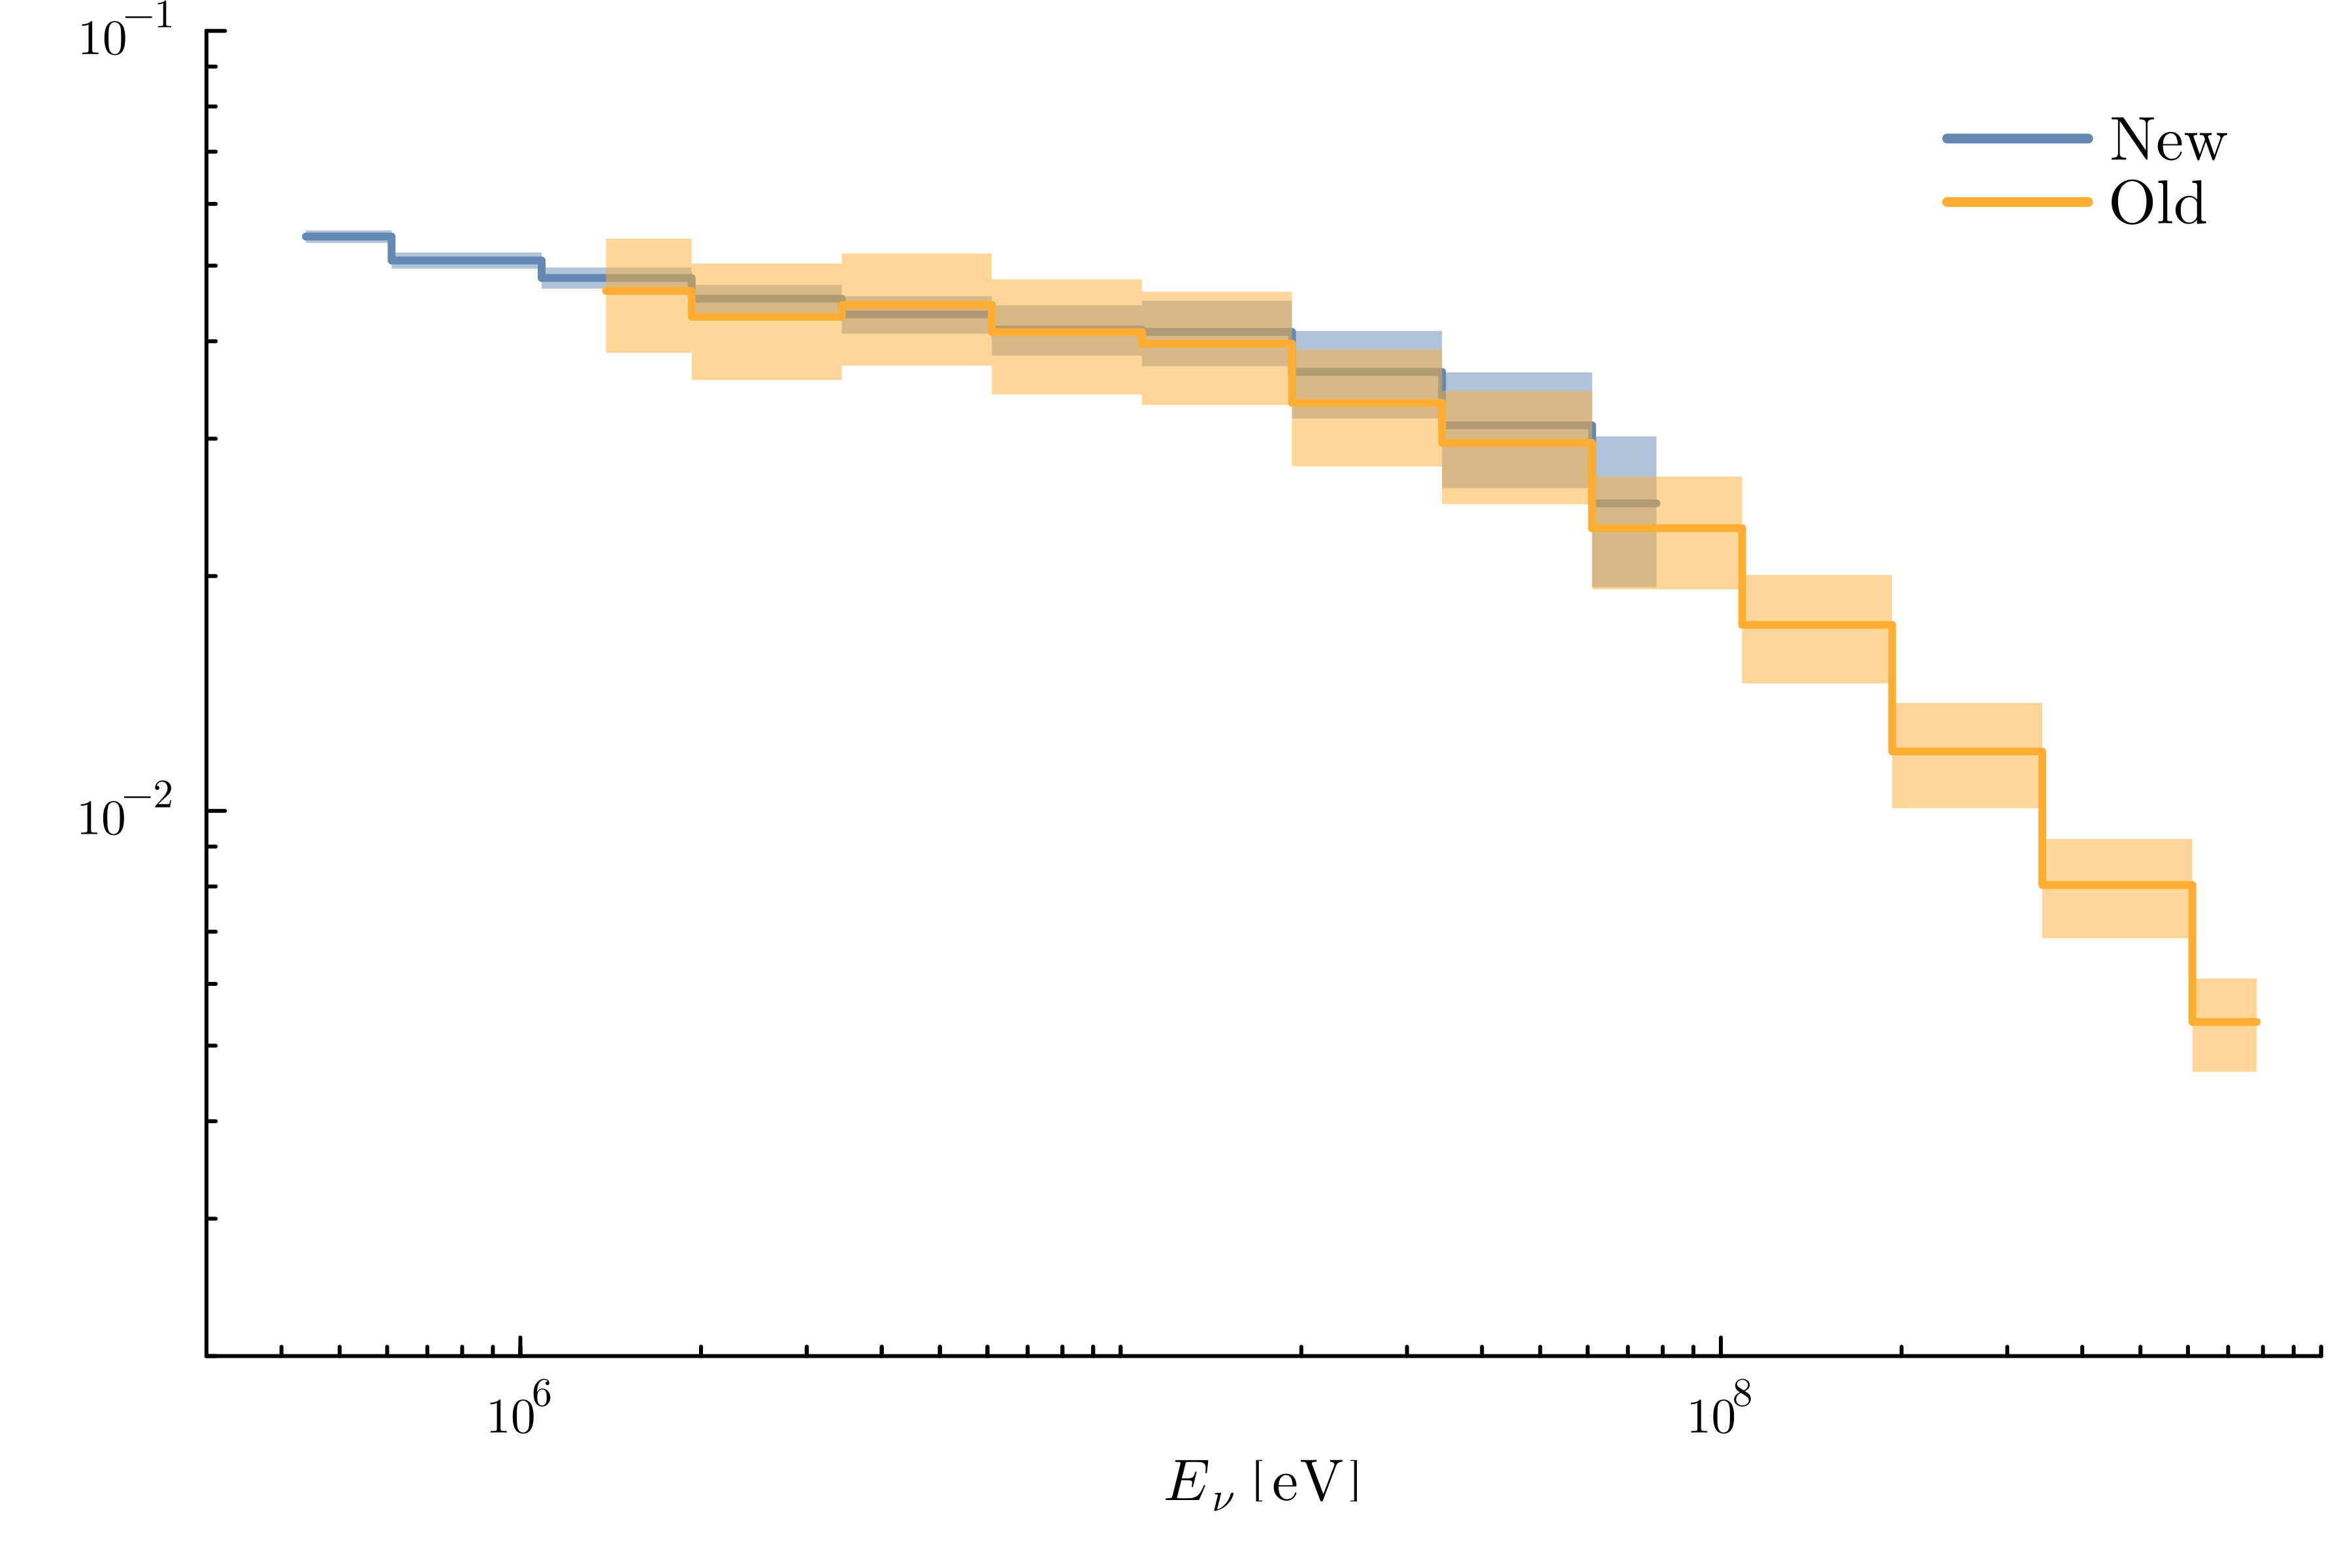

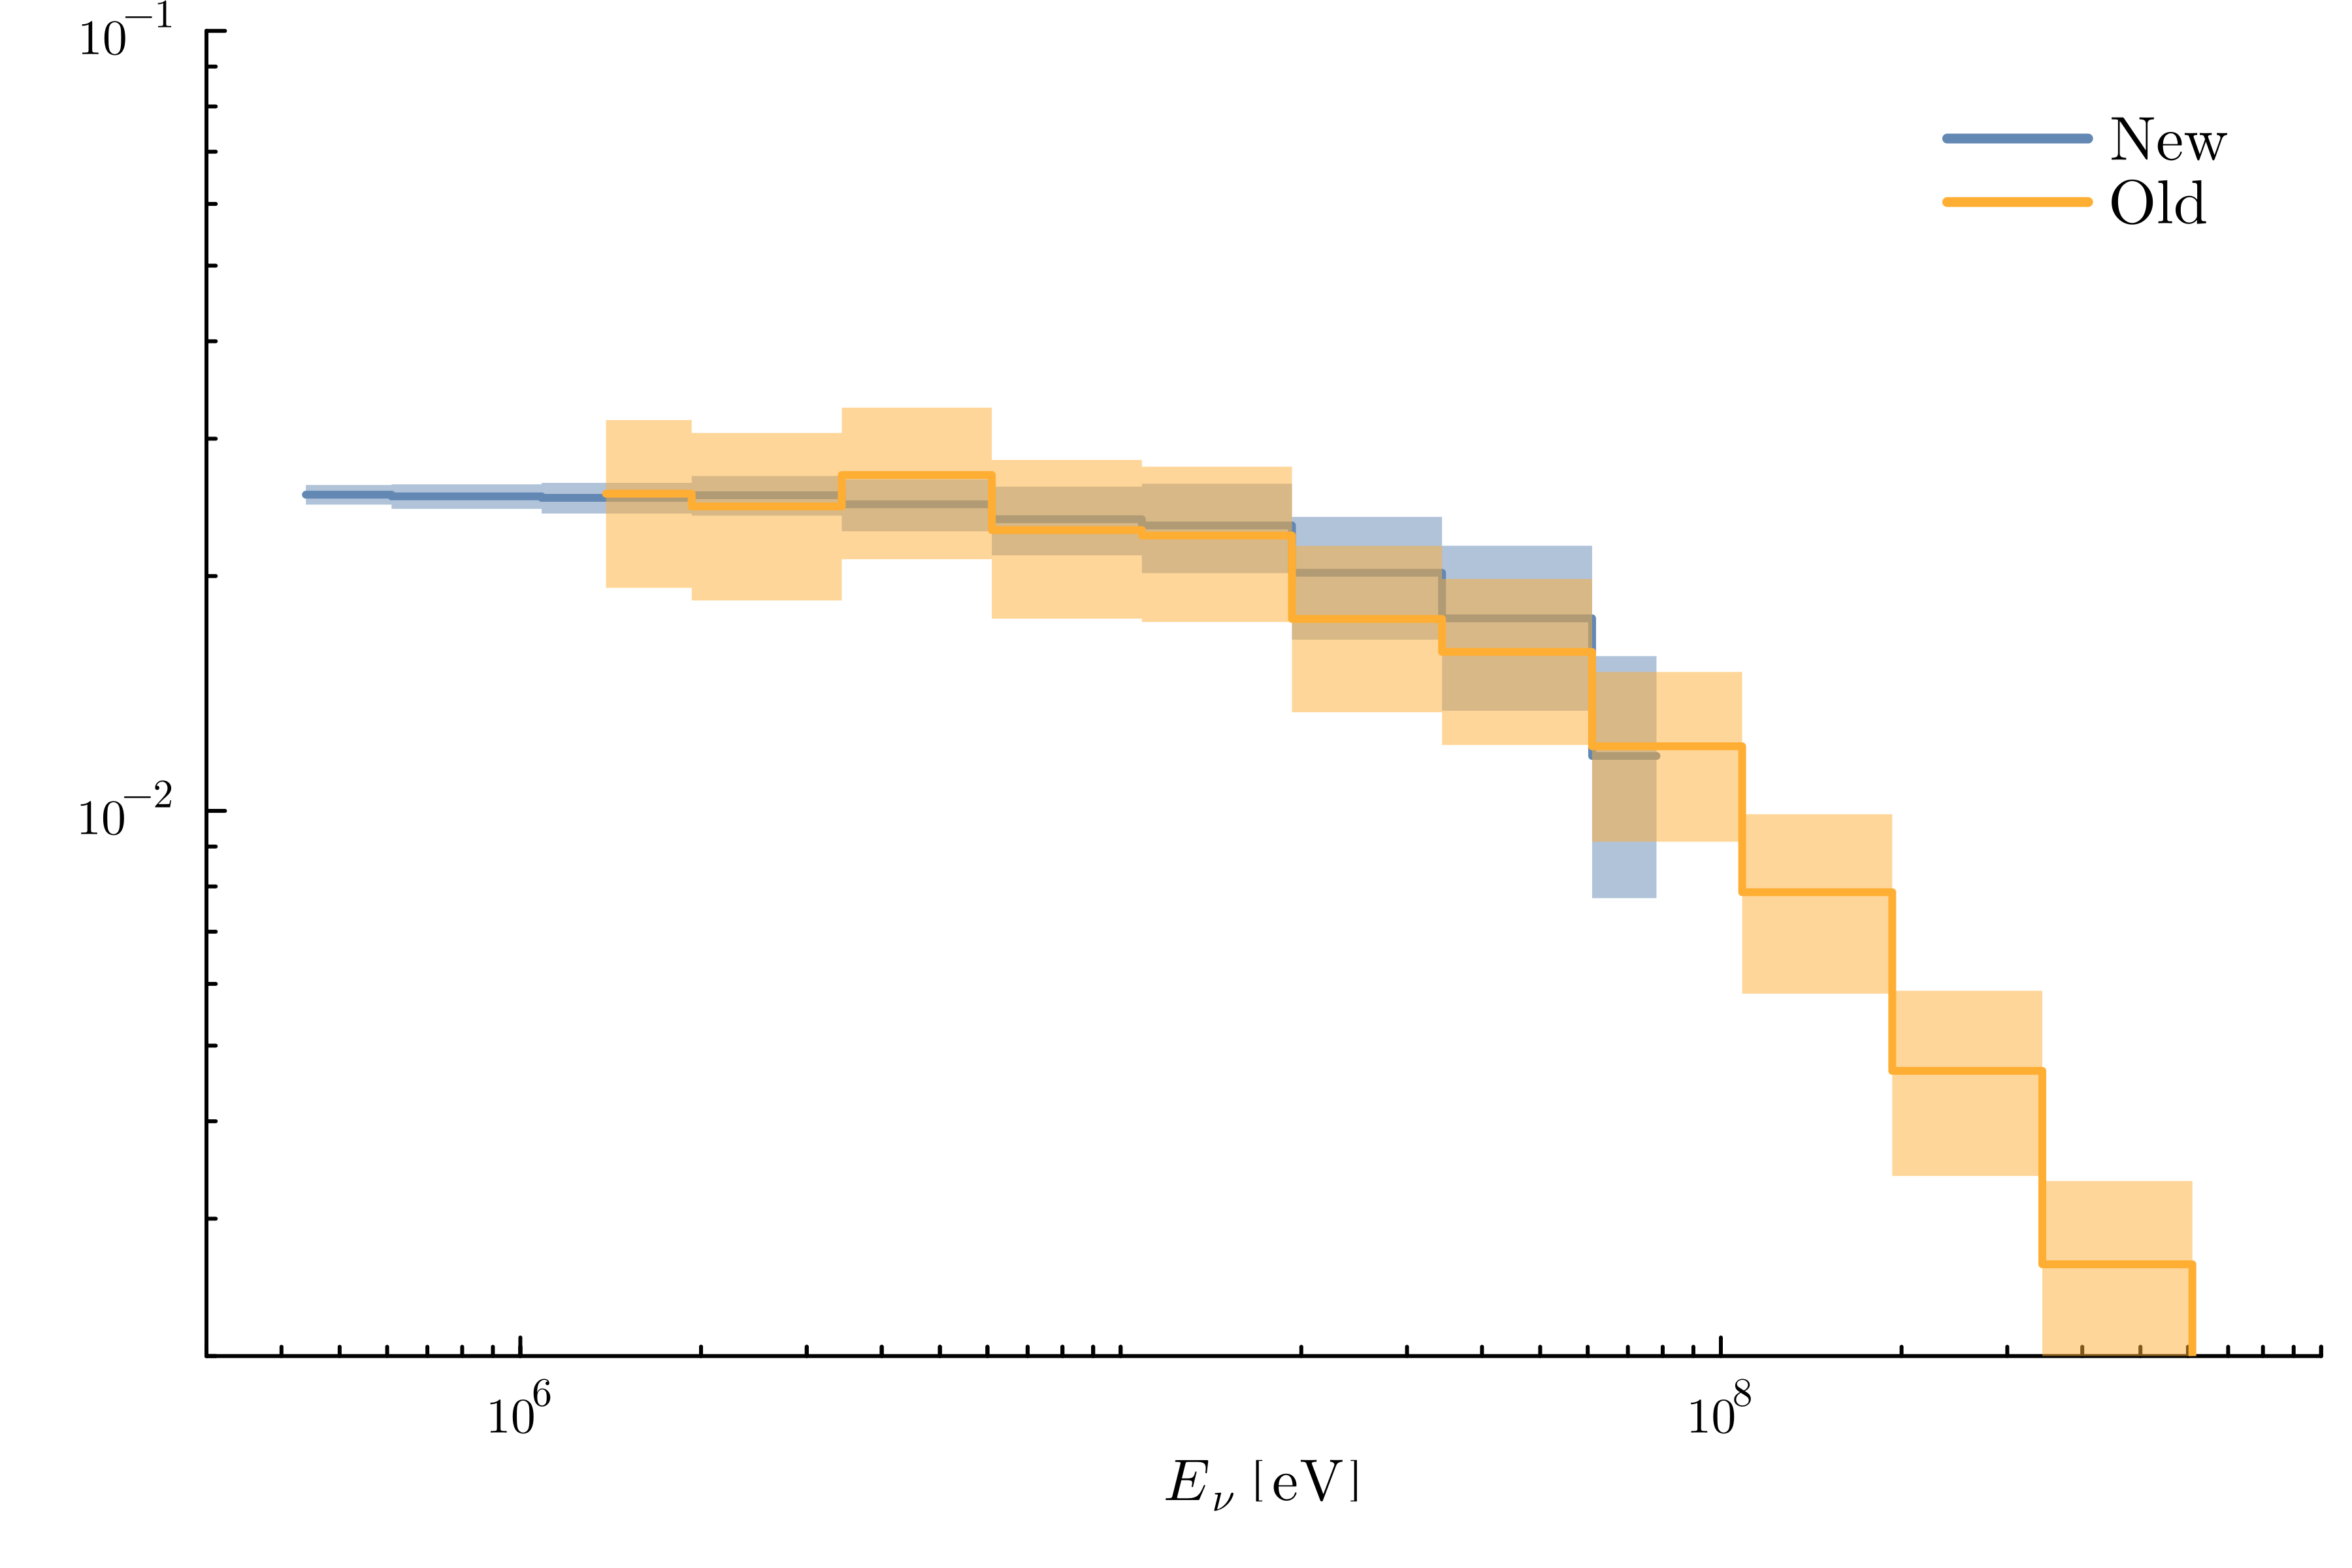

In [219]:
for jdx in 2:3
    
    plt = plot(
        xscale=:log10,
        # yscale=:log10,
        yaxis=(:log10, [2e-3, 1e-1]),
        xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
        bottommargin=3mm,
        leftmargin=3mm,
        xlimits=(3e5, 1e9),
        size=(600, 400)
    )
    
    for idx in 1:2

        label = idx==1 ? "New" : "Old"

        rate = HISTS[idx, jdx, 1, :] * units.second * 10^7.5
        err = 5 * sqrt.(HISTS[idx, jdx, 2, :]) * units.second * 10^7.5
        m = rate .> 0

        plot!(
            plt,
            CENTS[m] ./ units.GeV,
            rate[m],
            label=label,
            ribbon=err[m],
            linetype=:stepmid
        )
    end
    display(plt)
end



### Let's once again look at the difference of the rates

It looks like there is potentially some systematic behavior, but these look close enough. From here on out, I am going to consider only the new simulation

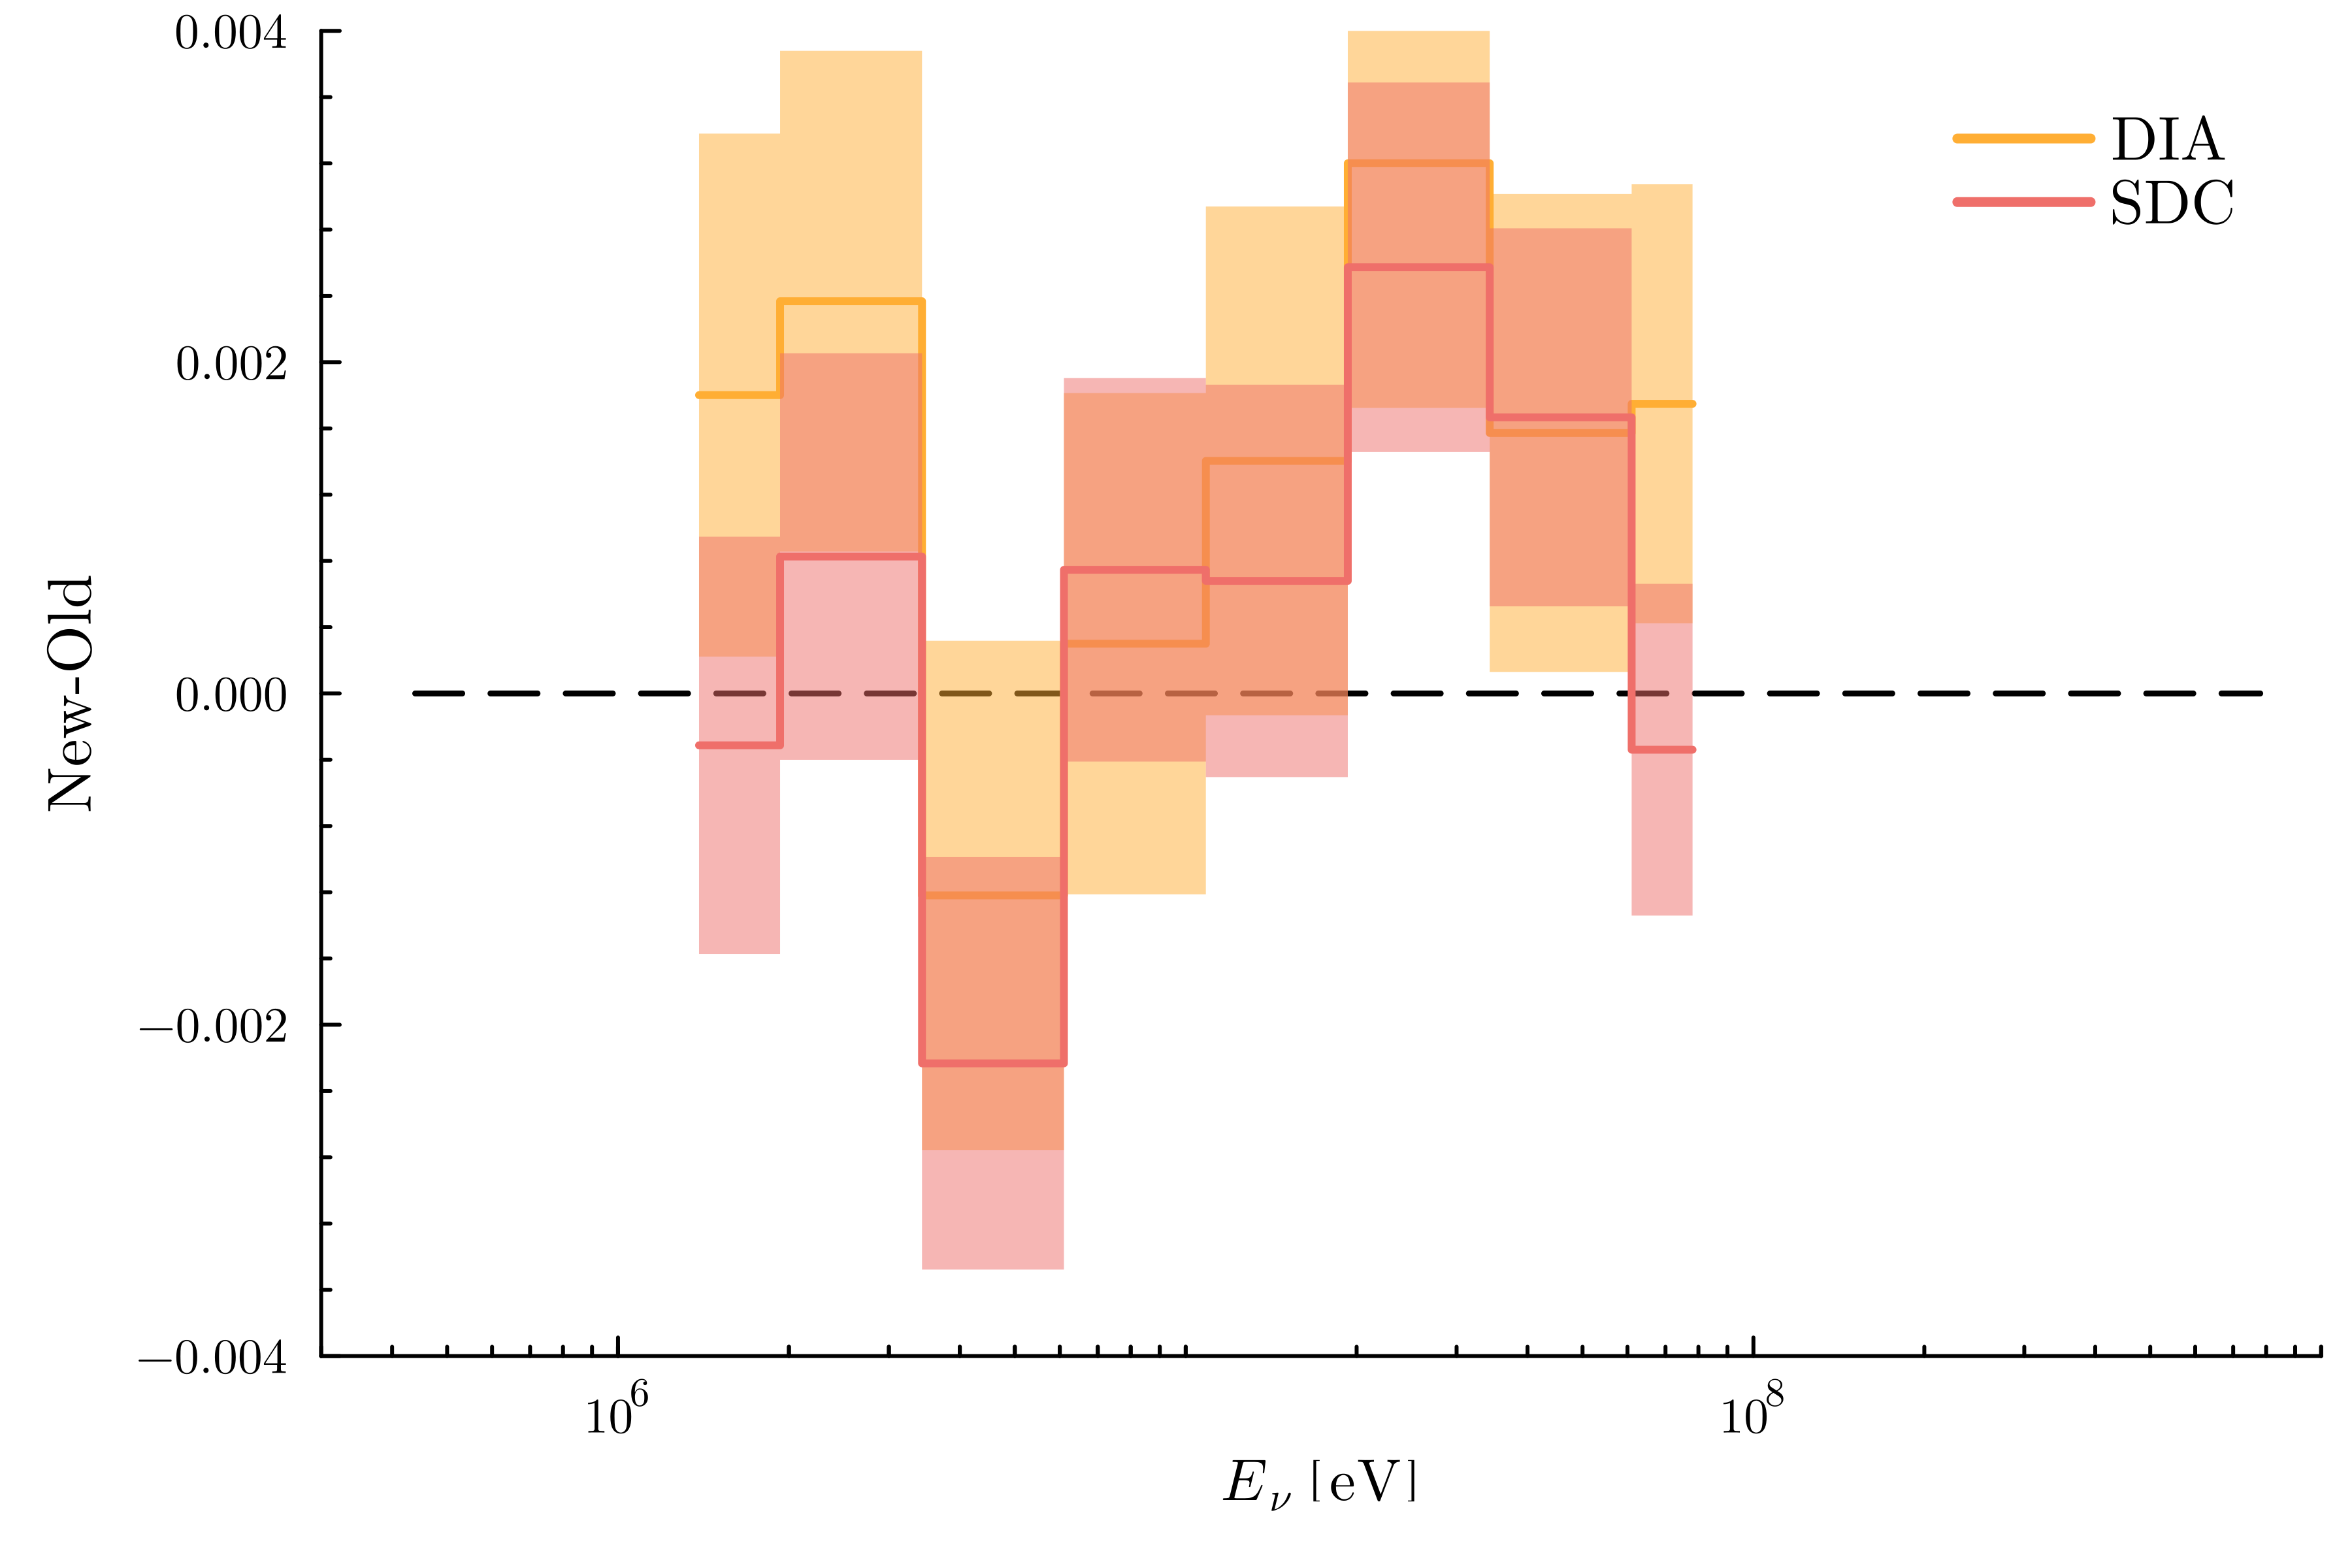

In [220]:
plt = plot(
    xscale=:log10,
    xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
    ylabel="New-Old",
    bottommargin=3mm,
    leftmargin=3mm,
    xlimits=(3e5, 1e9),
    ylimits=(-0.004, 0.004),
    size=(600, 400)
)

plot!(
    plt,
    [CENTS[1], CENTS[end]] / units.GeV,
    [0, 0],
    linestyle=:dash,
    color=:black, 
    lw=1.5
)

labels = ["", "DIA", "SDC"]

for idx in 2:3

    label = labels[idx]
    
    rate1 = HISTS[1, idx, 1, :] * units.second * 10^7.5
    err1 = sqrt.(HISTS[1, idx, 2, :]) * units.second * 10^7.5
    rate2 = HISTS[2, idx, 1, :] * units.second * 10^7.5
    err2 = sqrt.(HISTS[2, idx, 2, :]) * units.second * 10^7.5
    m = rate1 .> 0 .&& rate2 .> 0
    
    plot!(
        plt,
        CENTS[m] ./ units.GeV,
        rate1[m] - rate2[m],
        label=label,
        ribbon=sqrt.(err1[m] .^2 + err2[m] .^2),
        linetype=:stepmid
    )
end

display(plt)

# Now I want to look at the injection spectrum a bit more closely.

By eye, it does not seem that the spectrum is following the expected $E^{-2.37}$. Looking at it a bit more closely here, it is pretty clear that this is not falling off like $E^{-2.37}$, but rather something like $E^{-1.7}$. Somehow we are getting an extra power of 0.66 or so. I guess we expect a factor of 0.33 or so from the cross section.

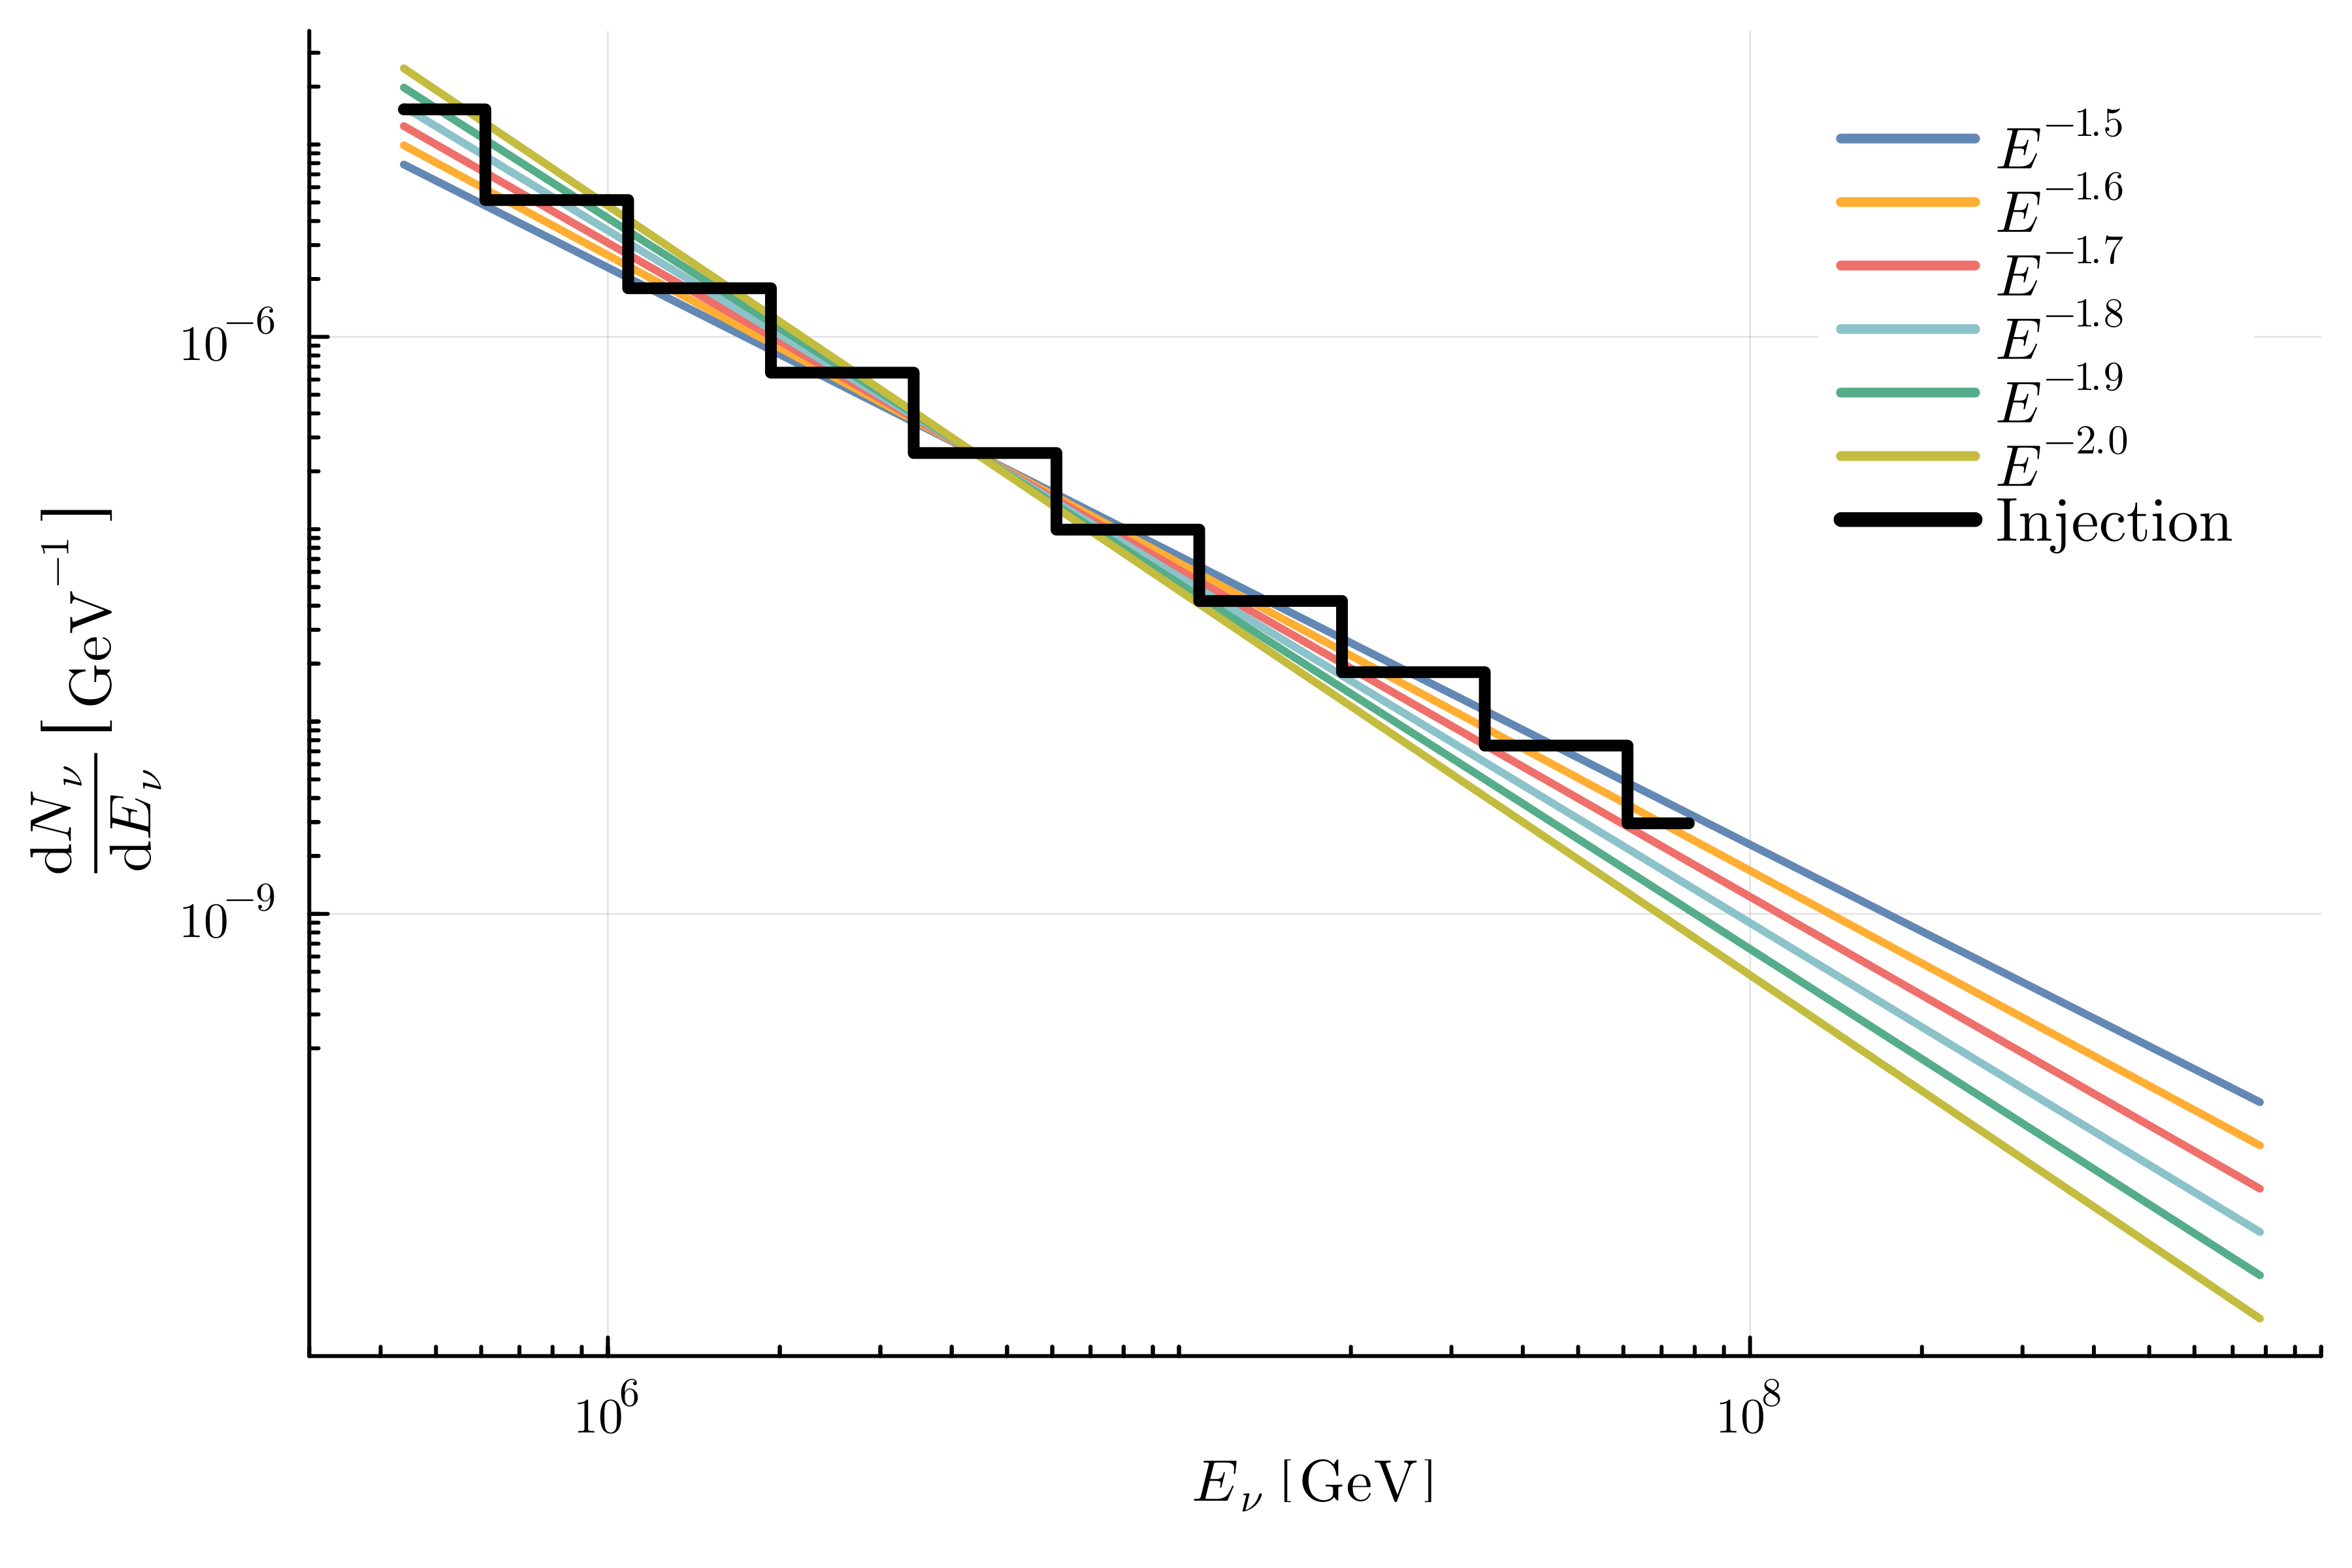

In [239]:
plt = plot(
    xscale=:log10,
    yscale=:log10,
    # yaxis=(:log10, [:auto, :auto]),
    xlabel=L"E_{\nu}~\left[\mathrm{GeV}\right]",
    ylabel=L"\frac{\mathrm{d}N_{\nu}}{\mathrm{d}E_{\nu}}~\left[\mathrm{GeV}^{-1}\right]",
    bottommargin=3mm,
    leftmargin=3mm,
    xlimits=(3e5, 1e9),
    size=(600, 400)
)

rate = HISTS[1, 1, 1, :] * units.second * 10^7.5
err = 5 * sqrt.(HISTS[1, 1, 2, :]) * units.second * 10^7.5
m = rate .> 0

for γ′ in 1.5:0.1:2.0

    plot!(
        plt,
        CENTS / units.GeV,
        CENTS .^ -γ′ * (HISTS[1,1,1,5] * units.second * 10^7.5/WIDTHS[5]*units.GeV / CENTS[5]^-γ′),
        label=L"E^{-%$(γ′)}"
    )
end

plot!(
    plt,
    CENTS[m] ./ units.GeV,
    rate[m] ./ (WIDTHS[m] / units.GeV),
    label="Injection",
    linetype=:stepmid,
    grid=true,
    lw=3,
    color=:black
)

display(plt)

# Sandbox

In [322]:
jldf = jldopen(sim_fs[1])

JLDFile /Users/jlazar/Downloads/GraphNet_00000/00000_00001/GraphNet_00000_00001.jld2 (read-only)
 ├─🔢 injected_events
 ├─🔢 proposal_events
 └─🔢 config

In [323]:
events = jldf["injected_events"]

20000-element Vector{Tambo.InjectionEvent}:
 Tambo.InjectionEvent(Particle(pdg_mc=16, energy=529547.6477184256 GeV, position=[-1312.3563101243983, -11244.03631965433, -3698.4754077247076]m, direction=(67.8°, 77.2°)), Particle(pdg_mc=16, energy=529547.6477184256 GeV, position=[-1312.3563101243983, -11244.03631965433, -3698.475407724857]m, direction=(67.8°, 77.2°)), Particle(pdg_mc=15, energy=454664.5603986933 GeV, position=[452.2914256125869, -3494.3617022065446, -454.82816294543363]m, direction=(67.8°, 77.2°)), 6.750994968814164e27, 6.750994968814164e27)
 Tambo.InjectionEvent(Particle(pdg_mc=16, energy=316407.3536190245 GeV, position=[19501.256994113424, 6001.617677506101, 5000.0]m, direction=(104.0°, 198.0°)), Particle(pdg_mc=16, energy=316407.3536190245 GeV, position=[19501.256994113424, 6001.617677506101, 5000.0]m, direction=(104.0°, 198.0°)), Particle(pdg_mc=15, energy=258890.8101134827 GeV, position=[85.04060884475295, -172.7024627173861, -106.25479705987935]m, direction=(104.0°, 

In [324]:
function impact_parameter(p, d)
    r = norm_(p)
    return r * sqrt(1 - (sum(p .* d) / r)^2)
end

function impact_parameter(event)
    p = event.entry_state.position 
    d = event.entry_state.direction.proj
    return impact_parameter(p, d)
end

impact_parameter (generic function with 2 methods)

In [337]:
bs = impact_parameter.(events) ./ units.km
h = fit(Histogram, bs)


plt = plot(h.edges[1][1:end-2], h.weights)
display(plt)

In [278]:
ev.final_state.position ./ units.km

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.4522914256125869
 -3.4943617022065445
 -0.4548281629454336

In [281]:
(ev.final_state.position - ev.entry_state.position) ./ ev.final_state.direction.proj

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 4.3503654495704704e10
 4.3503654495704704e10
 4.350365449570269e10

In [345]:
sim = jldopen(sim_fs[1])
config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
geo = Tambo.Geometry(config)
plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
injector = Tambo.Injector(config)

# Mask proper zenith range
# zenith_mask = is_in_zenith_range.(sim["injected_events"])
events = sim["injected_events"]

# Calculate decay in air and should do CORSIKA masks
# dia_mask = .~Tambo.inside.(sim["proposal_events"][zenith_mask]["propped_state"]["position"], Ref(geo))
# sdc_mask = Tambo.should_do_corsika.(sim["proposal_events"][zenith_mask], Ref(plane), Ref(geo))

# Calculate rates
fluxes = Φ.(events["initial_state"]["energy"])
weights = Tambo.oneweight.(
    events,
    Ref(injector.xs),
    Ref(injector.xs),
    Ref(injector.powerlaw),
    Ref(injector.anglesampler),
    Ref(injector.injectionvolume),
    Ref(geo)
)

20000-element Vector{Real}:
 1.2706974306831613e31
 7.8539722095478e29
 1.766466110827121e31
 8.968078183961065e33
 2.9215504555007543e30
 5.4428330987070336e32
 4.317073987041893e31
 1.5982420865774412e29
 2.755203184014174e31
 1.2470475555477814e30
 0
 5.925228360763661e32
 1.0718202182069846e31
 ⋮
 7.944288914957113e30
 4.468336809041895e31
 2.219887136690772e34
 7.921776323988702e31
 6.5093640628476675e31
 7.028308741973556e34
 2.8231364973885162e29
 1.8651965745989628e30
 2.654964946718129e32
 3.242994352162585e31
 1.1241192293131204e31
 2.826525170925641e29

In [343]:
weights

Particle(pdg_mc=16, energy=37.72492592565567 GeV, position=[3936.191300716833, 1239.6973849824017, -10000.00000000031]m, direction=(23.3°, 175.0°))

In [139]:
jldf = jldopen("/Users/jlazar/Downloads/tambo_weighting_test_events.jld2")

JLDFile /Users/jlazar/Downloads/tambo_weighting_test_events.jld2 (read-only)
 ├─🔢 events1
 ├─🔢 events2
 ├─🔢 config2
 └─🔢 config1

In [40]:
jldf["config1"]

General configuration
_____________________
n: 50000
seed: 925
run_n: 853

Geometry configuration
______________________
geo_spline_path: ../resources/tambo_spline.jld2
tambo_coordinates: (-15.66465°, -72.15475°)

Injection configuration
_______________________
ν_pdg: 16
γ: 1.0
emin: 1.0e6 GeV
emax: 1.0e9 GeV
θmin: 0.0°
θmax: 180.0°
ϕmin: 0.0°
ϕmax: 360.0°
r_injection: 2000.0 m
l_endcap: 1000.0 m
diff_xs_path: /n/home12/jlazar/TAMBO-MC/resources/cross_sections/tables/csms_differential_cdfs.h5

PROPOSAL configuration
______________________
ecut: Inf GeV
vcut: 0.01
do_interpolate: true
do_continuous: true
tablespath: /n/home12/jlazar/TAMBO-MC/resources/proposal_tables

In [3]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

for idx in 1:2
    config = jldf["config$(idx)"]
    config.geo_spline_path = "../resources/tambo_spline.jld2"
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    # @show config
    
    events = jldf["events$(idx)"]
    
    # mask =. units.PeV .< events["initial_state"]["energy"] .&& 
    
    fluxes = Φ.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    rates = weights .* fluxes * units.second * 10^7.5
    @show sum(rates)
    @show √(sum(rates .^ 2))
end

sum(rates) = 20.525288097870188
√(sum(rates .^ 2)) = 0.21163599069744046
sum(rates) = 20.49511226635734
√(sum(rates .^ 2)) = 0.18096760925040745


In [4]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

jldf = jldopen("/Users/jlazar/Downloads/tambo_weighting_test_events3.jld2")

for idx in 1:2
    config = SimulationConfig(;jldf["config$(idx)"]...)
    config.geo_spline_path = "../resources/tambo_spline.jld2"
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
        
    events = jldf["injection_events$(idx)"]
    
    # mask =. units.PeV .< events["initial_state"]["energy"] .&& 
    
    fluxes = Φ.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    rates = weights .* fluxes * units.second * 10^7.5
    @show sum(rates)
    @show √(sum(rates .^ 2))
end

close(jldf)

sum(rates) = 22.106988126305914
√(sum(rates .^ 2)) = 0.1626328387368701
sum(rates) = 22.01750150477682
√(sum(rates .^ 2)) = 0.1230856809539325


In [5]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

jldf = jldopen("/Users/jlazar/Downloads/tambo_weighting_test_events3.jld2")

for idx in 1:2
    config = SimulationConfig(;jldf["config$(idx)"]...)
    config.geo_spline_path = "../resources/tambo_spline.jld2"
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)

    mask = .~Tambo.inside.(jldf["proposal_events$(idx)"]["propped_state"]["position"], Ref(geo))
    
    events = jldf["injection_events$(idx)"][mask]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    rates = weights .* fluxes * units.second * 10^7.5
    @show sum(rates)
    @show √(sum(rates .^ 2))
end

close(jldf)

sum(rates) = 0.5596652279879445
√(sum(rates .^ 2)) = 0.012116147751121345
sum(rates) = 0.5615073764613345
√(sum(rates .^ 2)) = 0.02737869936117412


In [6]:
(0.6092861046390421 - 0.5856487232555672) / √(0.020122981644587333^2 + 0.034624810399983406^2)

0.5902318602708125

In [7]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

jldf = jldopen("/Users/jlazar/Downloads/tambo_weighting_test_events3.jld2")

for idx in 1:2
    config = SimulationConfig(;jldf["config$(idx)"]...)
    config.geo_spline_path = "../resources/tambo_spline.jld2"
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)

    mask = Tambo.should_do_corsika.(jldf["proposal_events$(idx)"], Ref(plane), Ref(geo))
    
    events = jldf["injection_events$(idx)"][mask]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    rates = weights .* fluxes * units.second * 10^7.5
    @show sum(rates)
    @show √(sum(rates .^ 2))
end

close(jldf)

sum(rates) = 0.22684340795615593
√(sum(rates .^ 2)) = 0.008569804138275449
sum(rates) = 0.24146143158390668
√(sum(rates .^ 2)) = 0.020307561167538703


In [8]:
(0.24129219291299478 - 0.23949863872500352) / √(0.012974998861612498^2 + 0.020305556997366664^2)

0.07443054753423656

In [9]:
EDGES = 10 .^ (log(10, 3e14):0.25:18)
CENTS = (EDGES[1:end-1] + EDGES[2:end]) / 2
WIDTHS = EDGES[2:end] - EDGES[1:end-1]

14-element Vector{Float64}:
 2.33483823011676e14
 4.151994750388354e14
 7.383406775205308e14
 1.312976024428948e15
 2.33483823011676e15
 4.151994750388353e15
 7.383406775205376e15
 1.3129760244289534e16
 2.3348382301167692e16
 4.1519947503883704e16
 7.383406775205339e16
 1.3129760244289533e17
 2.3348382301167693e17
 4.151994750388371e17

## Now we're gonna make some plots

sum(rates) = 22.106988126305914
√(sum(rates .^ 2)) = 0.1626328387368701
sum(rates) = 22.01750150477682
√(sum(rates .^ 2)) = 0.1230856809539325


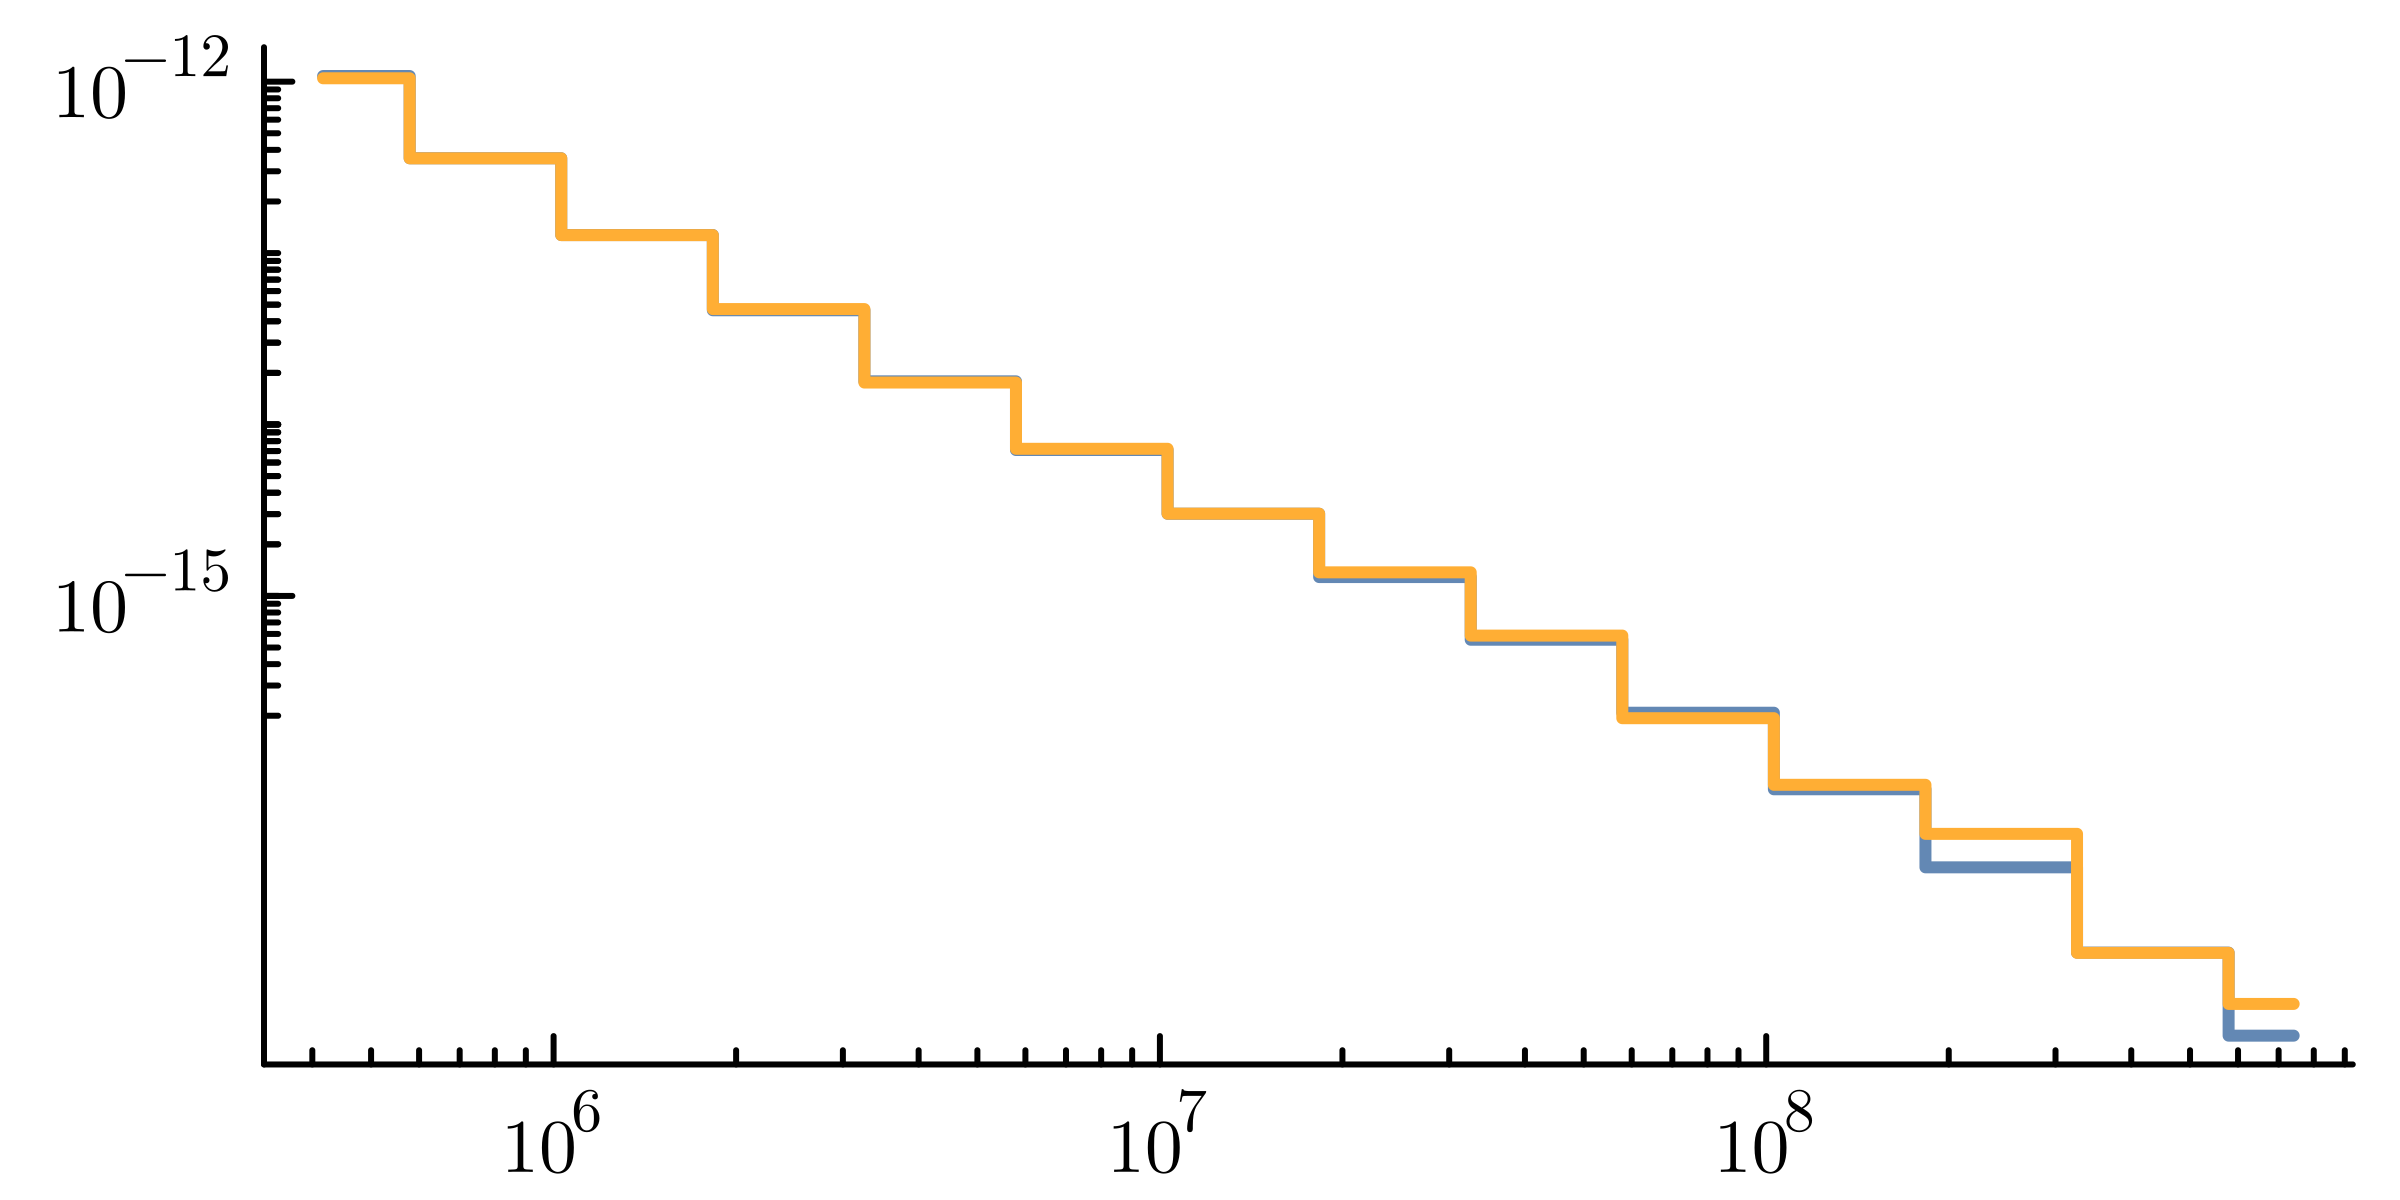

In [10]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

jldf = jldopen("/Users/jlazar/Downloads/tambo_weighting_test_events3.jld2")

plt = plot(xscale=:log10, yscale=:log10)

for idx in 1:2
    config = SimulationConfig(;jldf["config$(idx)"]...)
    config.geo_spline_path = "../resources/tambo_spline.jld2"
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)

    # mask = .~Tambo.inside.(jldf["proposal_events$(idx)"]["propped_state"]["position"], Ref(geo))
    
    events = jldf["injection_events$(idx)"]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    rates = weights .* fluxes * units.second * 10^7.5
    
    h = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(weights .* fluxes),
        EDGES
    )
    
    plot!(
        plt, CENTS / units.GeV,
        h.weights ./ WIDTHS * units.second * units.GeV,
        linetype=:stepmid
    )
    
    @show sum(rates)
    @show √(sum(rates .^ 2))
end
display(plt)
close(jldf)

sum(rates) = 0.5596652279879445
√(sum(rates .^ 2)) = 0.012116147751121345
sum(rates) = 0.5615073764613345
√(sum(rates .^ 2)) = 0.02737869936117412


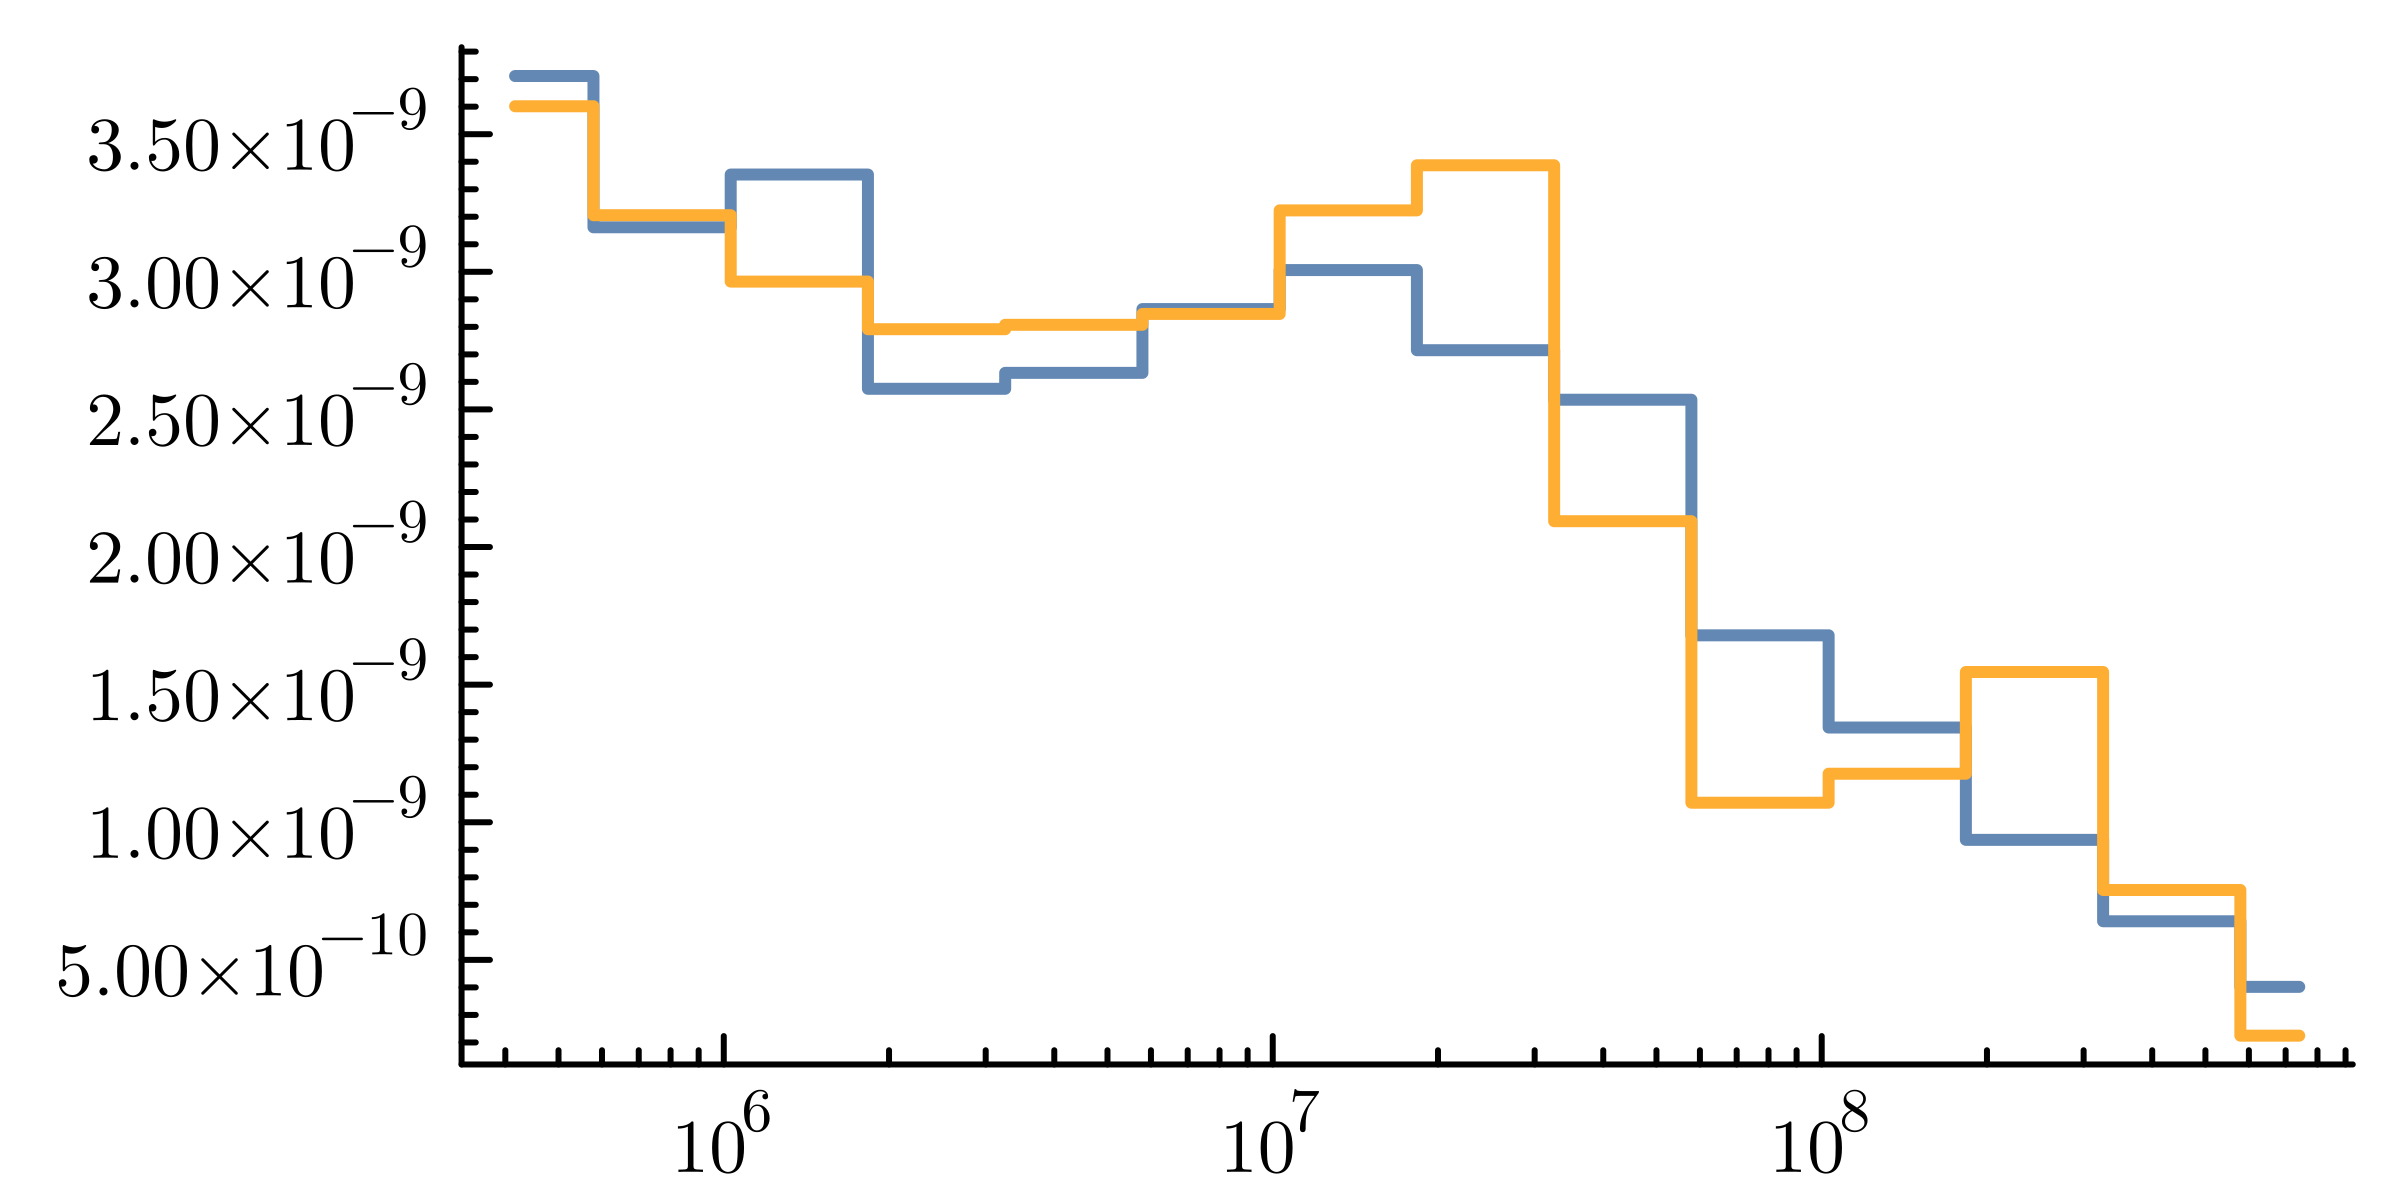

In [11]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

jldf = jldopen("/Users/jlazar/Downloads/tambo_weighting_test_events3.jld2")

plt = plot(xscale=:log10)

for idx in 1:2
    config = SimulationConfig(;jldf["config$(idx)"]...)
    config.geo_spline_path = "../resources/tambo_spline.jld2"
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)

    mask = .~Tambo.inside.(jldf["proposal_events$(idx)"]["propped_state"]["position"], Ref(geo))
    
    events = jldf["injection_events$(idx)"][mask]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    rates = weights .* fluxes * units.second * 10^7.5
    
    h = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(weights .* fluxes),
        EDGES
    )
    
    plot!(plt, CENTS / units.GeV, h.weights / WIDTHS * CENTS * units.second, linetype=:stepmid)
    
    @show sum(rates)
    @show √(sum(rates .^ 2))
end
display(plt)
close(jldf)

config = General configuration
_____________________
n: 100000
seed: 523
run_n: 853

Geometry configuration
______________________
geo_spline_path: /n/home12/jlazar/TAMBO-MC/resources/tambo_spline.jld2
tambo_coordinates: (-15.66465°, -72.15475°)

Injection configuration
_______________________
ν_pdg: 16
γ: 1.0
emin: 300000.0 GeV
emax: 1.0e9 GeV
θmin: 0.0°
θmax: 117.0°
ϕmin: 51.0°
ϕmax: 231.0°
r_injection: 2000.0 m
l_endcap: 1000.0 m
diff_xs_path: /n/home12/jlazar/TAMBO-MC/resources/cross_sections/tables/csms_differential_cdfs.h5

PROPOSAL configuration
______________________
ecut: Inf GeV
vcut: 0.01
do_interpolate: true
do_continuous: true
tablespath: /n/home12/jlazar/TAMBO-MC/resources/proposal_tables
sum(rates) = 0.22684340795615593
√(sum(rates .^ 2)) = 0.008569804138275449
config = General configuration
_____________________
n: 100000
seed: 512
run_n: 853

Geometry configuration
______________________
geo_spline_path: /n/home12/jlazar/TAMBO-MC/resources/tambo_spline.jld2
tambo_coord

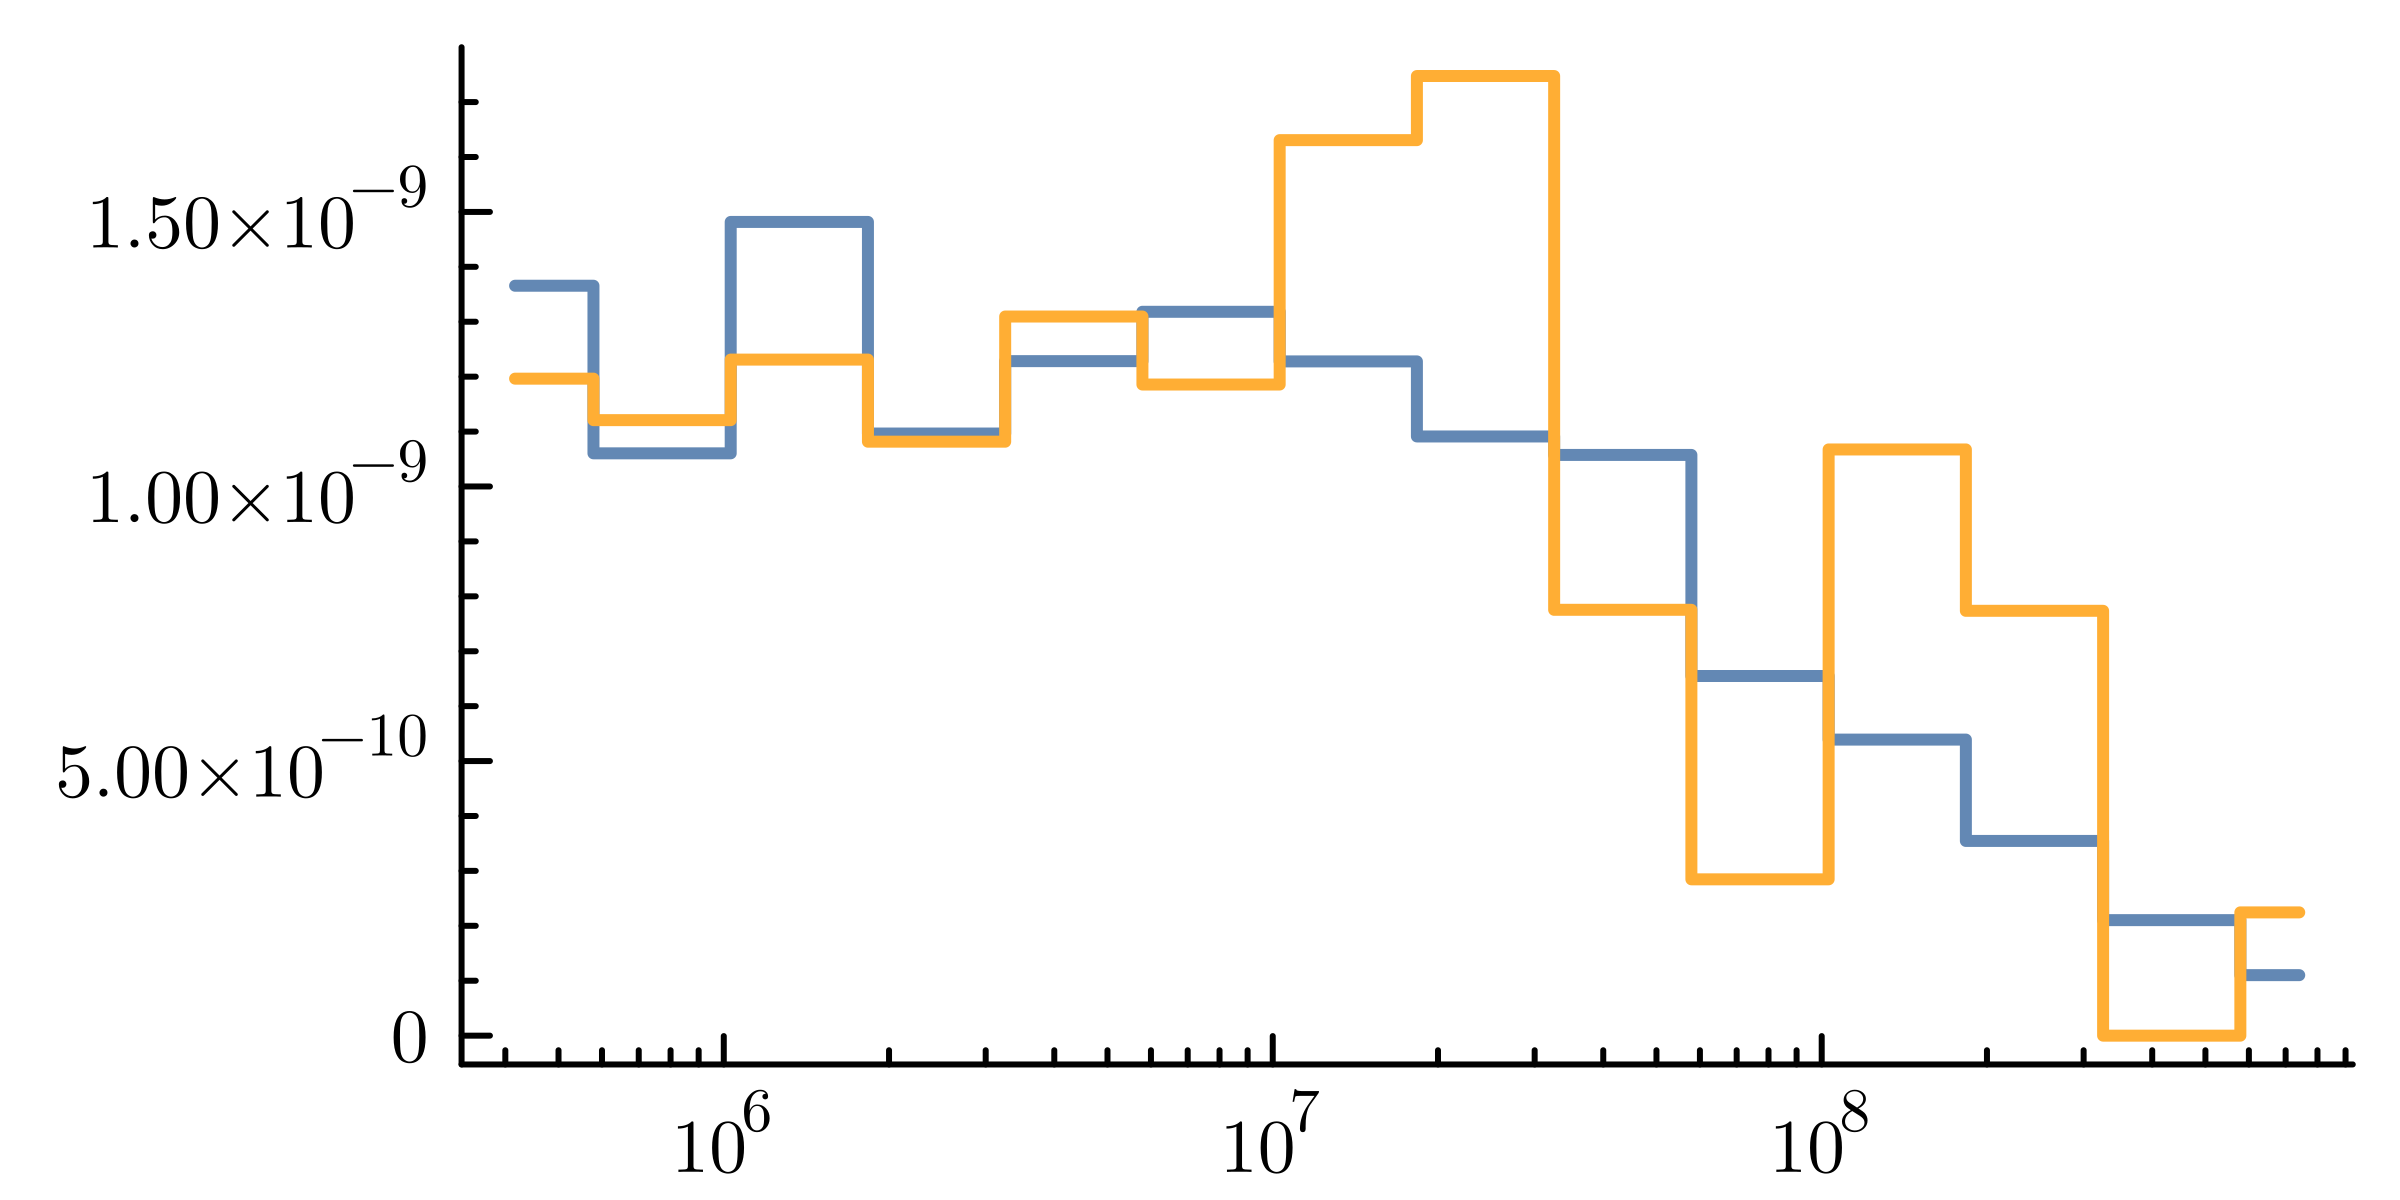

In [12]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

jldf = jldopen("/Users/jlazar/Downloads/tambo_weighting_test_events3.jld2")

plt = plot(xscale=:log10)

for idx in 1:2
    config = SimulationConfig(;jldf["config$(idx)"]...)
    
    @show config
    
    config.geo_spline_path = "../resources/tambo_spline.jld2"
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)

    mask = Tambo.should_do_corsika.(jldf["proposal_events$(idx)"], Ref(plane), Ref(geo))
    
    events = jldf["injection_events$(idx)"][mask]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    rates = weights .* fluxes * units.second * 10^7.5
    
    h = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(weights .* fluxes),
        EDGES
    )
    
    plot!(plt, CENTS / units.GeV, h.weights / WIDTHS * CENTS * units.second, linetype=:stepmid)
    
    @show sum(rates)
    @show √(sum(rates .^ 2))
end
display(plt)
close(jldf)